# Comparison between ATAC-seq and RNA-seq expression profiles

## 1. Gene Clustering and Cell Type Clustering

First, we are comparing the ATAC-peak accessibility and gene expression profiles per cell types. The respective codes and further explanations can be found in the gene_expression_clustering and ATAC_clustering_analysis notebooks. Here, we will only paste the results for comparison.

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load and prepare RNA-seq matrix
df = pd.read_csv("mmc2.csv", index_col=0)

cell_types_to_keep = [
    "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.4.Sp.aCD3+CD40.18hr", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "T8.TN.P14.Sp", "T8.TE.LCMV.d7.Sp", "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.Gut",
    "T8.Tcm.LCMV.d180.Sp", "T8.Tem.LCMV.d180.Sp",
    "NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d",
    "LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"
]

filtered_df = df[cell_types_to_keep]
filtered_df.to_csv("filtered_abT_Tact_Stem.csv")

# Calculate variance for each gene across the 29 cell types
gene_variances = filtered_df.var(axis=1)

# Filter genes by variance threshold as defined in the RNA-seq gene_expression_clustering notebook 
var_threshold = 500
high_var_genes = gene_variances[gene_variances > var_threshold].index
refined_df = filtered_df.loc[high_var_genes]

# Transpose: rows = samples (cell types), columns = features (genes)
transposed = refined_df.T

# Z-score scaling
scaler = StandardScaler()
transposed_scaled = scaler.fit_transform(transposed)

# Back to DataFrame with labels
transposed_scaled_df = pd.DataFrame(transposed_scaled, index=transposed.index, columns=transposed.columns)

# Use the already scaled data
rna_transposed = transposed_scaled_df  
rna_pca = PCA(n_components=2)
rna_pca_result = rna_pca.fit_transform(rna_transposed)
rna_pca_df = pd.DataFrame(rna_pca_result, columns=["PC1", "PC2"], index=rna_transposed.index)
rna_pca_df["CellType"] = rna_pca_df.index

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load and prepare the ATAC-seq matrix
peak_matrix = pd.read_csv("ATAC_high_var.csv")
signal_matrix = peak_matrix.iloc[:, 8:-1] # exclude the first 8 columns since they are annotations and we don't need them

# Tranpose matrix
atac_transposed = signal_matrix.T
atac_transposed.head()

0      1      2      3      4      5      6      7      8      \
preT.DN1.Th   14.81  59.36  40.73  23.05  20.15  10.18  36.51  12.79  17.42   
preT.DN2a.Th  22.31  43.17  28.06   8.10   7.29  17.64  43.92   8.76  21.59   
preT.DN2b.Th   5.17  50.58  12.60   8.83   2.67  15.71  14.61   4.77  20.48   
preT.DN3.Th    2.00  28.94  30.46  13.55   3.08  14.12  11.10   3.08  11.15   
T.DN4.Th       3.54   4.62  14.85   8.17   2.89   8.03   6.11   2.76   8.41   

              9      ...  75847  75848  75849  75850  75851  75852  75853  \
preT.DN1.Th    5.81  ...  26.59  19.05  24.77  34.10   3.47  16.26   9.35   
preT.DN2a.Th   6.49  ...  15.01  10.46  30.09  37.56   3.22  15.23  13.75   
preT.DN2b.Th   4.83  ...  16.36  11.95  47.10  33.86   4.83  23.51  25.28   
preT.DN3.Th    4.00  ...  22.34  24.17  38.09  37.96   5.90  17.92  15.38   
T.DN4.Th       2.29  ...  13.57  16.93  34.49  34.34   9.35  33.73  24.35   

              75854  75855  75856  
preT.DN1.Th    7.02  15.76  12.97  
preT.DN2a.Th  11.95  19.36  16.90  
preT.DN2b.Th  17.03  18.31  17.03  
preT.DN3.Th   19.55  18.56   9.20  
T.DN4.Th      27.28  19.63  17.73  

[5 rows x 75857 columns]

### Dimensionality reduction per cell type

After loading the datasets, we want to compare the chromatin accessibility and gene expression profiles per the different cell types.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


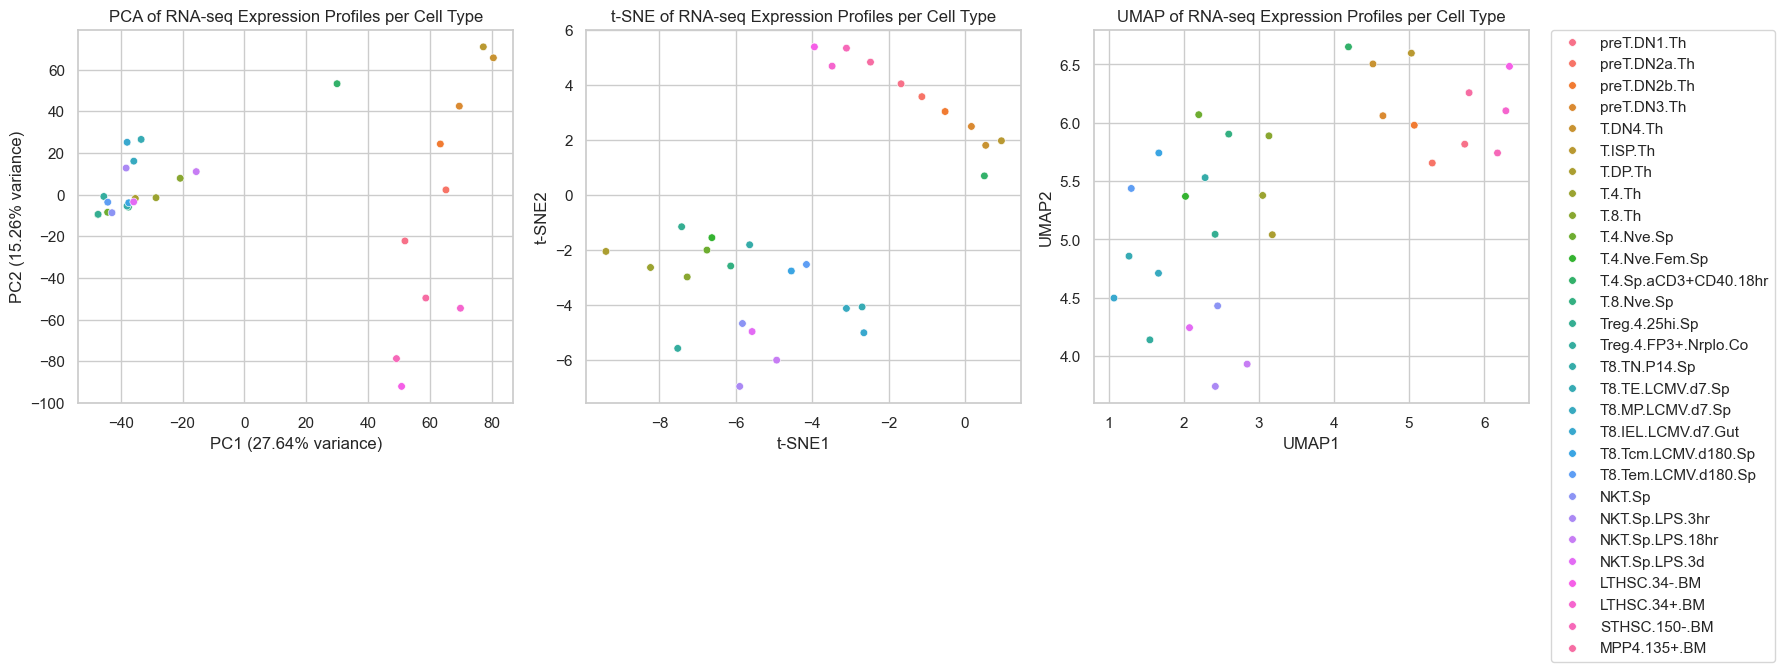

In [31]:
## PCA, UMAP, t-SNE of gene expression profiles per cell type

from sklearn.manifold import TSNE
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set style
sns.set(style="whitegrid")

# Create figure with 1 row and 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- PCA ---
sns.scatterplot(
    data=rna_pca_df,
    x="PC1", y="PC2",
    hue="CellType", s=30,
    ax=axes[0], legend=False
)
axes[0].set_title("PCA of RNA-seq Expression Profiles per Cell Type")
axes[0].set_xlabel(f"PC1 ({rna_pca.explained_variance_ratio_[0]*100:.2f}% variance)")
axes[0].set_ylabel(f"PC2 ({rna_pca.explained_variance_ratio_[1]*100:.2f}% variance)")

# --- t-SNE ---
rna_tsne_model = TSNE(n_components=2, random_state=42, perplexity=10)
rna_tsne_result = rna_tsne_model.fit_transform(transposed_scaled)
# Make a DataFrame
rna_tsne_df = pd.DataFrame(rna_tsne_result, columns=["t-SNE1", "t-SNE2"], index=refined_df.columns)
rna_tsne_df["CellType"] = rna_tsne_df.index

sns.scatterplot(
    data=rna_tsne_df,
    x="t-SNE1", y="t-SNE2",
    hue="CellType", s=30,
    ax=axes[1], legend=False
)
axes[1].set_title("t-SNE of RNA-seq Expression Profiles per Cell Type")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")

# --- UMAP ---
rna_umap_model = umap.UMAP(n_components=2, random_state=42)
rna_umap_result = rna_umap_model.fit_transform(transposed_scaled)
# Make a DataFrame
rna_umap_df = pd.DataFrame(rna_umap_result, columns=["UMAP1", "UMAP2"], index=refined_df.columns)
rna_umap_df["CellType"] = rna_umap_df.index

sns.scatterplot(
    data=rna_umap_df,
    x="UMAP1", y="UMAP2",
    hue="CellType", s=30,
    ax=axes[2]
)
axes[2].set_title("UMAP of RNA-seq Expression Profiles per Cell Type")
axes[2].set_xlabel("UMAP1")
axes[2].set_ylabel("UMAP2")

# Move legend to the right of UMAP plot
axes[2].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

# Final layout
plt.tight_layout()
plt.show()


**Fig. 1: PCA, UMAP, t-SNE of RNA-seq expression profiles per cell types**

It is visible that most cell types form distinct, compact clusters, especially in UMAP and t-SNE. Progenitors are well-separated from lymphoid lineages.Some naive and effector T cells are closely grouped, reflecting their similar expression. Interestingly, NKT subtypes cluster a little apart and nearby each other, they only partially overlap with the other T cells suggesting a more significant and distinct gene profile than the rest.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


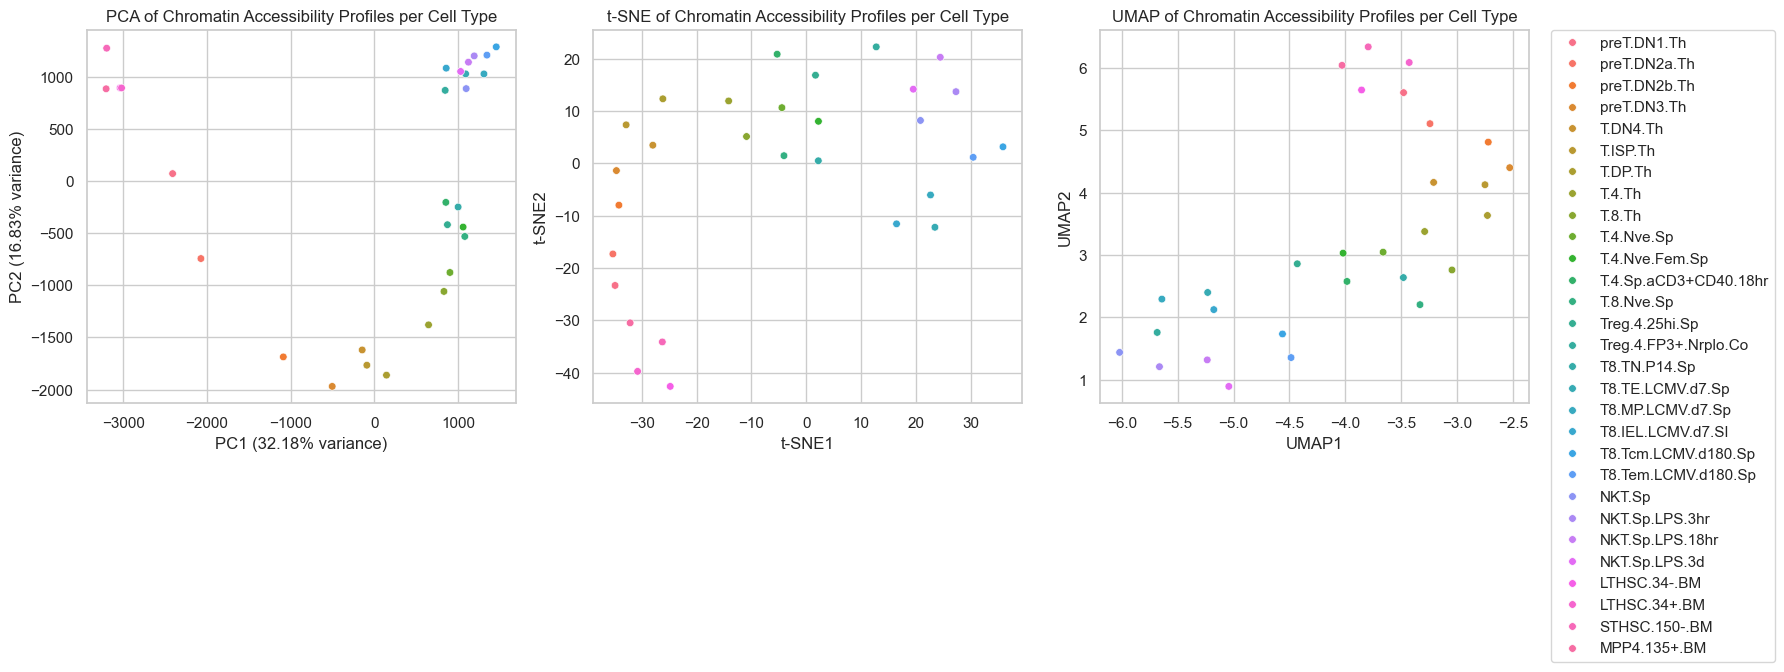

In [32]:
## PCA, UMAP, t-SNE of chromatin accessibility profiles per cell types
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Data Frame for PCA
subset = atac_transposed
atac_pca = PCA(n_components=2)
atac_pca_result = atac_pca.fit_transform(subset)
atac_pca_df = pd.DataFrame(atac_pca_result, columns=["PC1", "PC2"], index=subset.index)
atac_pca_df["CellType"] = atac_pca_df.index  # Making sure cell types are in a column

# Data Frame for UMAP
atac_umap_model = umap.UMAP(n_components=2, random_state=42)
atac_umap_result = atac_umap_model.fit_transform(subset)
atac_umap_df = pd.DataFrame(atac_umap_result, columns=["UMAP1", "UMAP2"], index=subset.index)
atac_umap_df = atac_umap_df.reset_index().rename(columns={"index": "CellType"})

# Data Frame for t-SNE
atac_tsne_model = TSNE(n_components=2, random_state=42, perplexity=10)
atac_tsne_result = atac_tsne_model.fit_transform(subset)
atac_tsne_df = pd.DataFrame(atac_tsne_result, columns=["t-SNE1", "t-SNE2"], index=subset.index)
atac_tsne_df = atac_tsne_df.reset_index().rename(columns={"index": "CellType"})

# Plotting PCA, UMAP, t-SNE side-by-side

# Setting style
sns.set(style="whitegrid")

# Creating figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 plots

# Plotting PCA
sns.scatterplot(
    data=atac_pca_df, x="PC1", y="PC2", hue="CellType", s=30, ax=axes[0], legend=False
)
axes[0].set_title("PCA of Chromatin Accessibility Profiles per Cell Type")
axes[0].set_xlabel(f"PC1 ({atac_pca.explained_variance_ratio_[0]*100:.2f}% variance)")
axes[0].set_ylabel(f"PC2 ({atac_pca.explained_variance_ratio_[1]*100:.2f}% variance)")

# Plotting t-SNE 
sns.scatterplot(
    data=atac_tsne_df, x="t-SNE1", y="t-SNE2", hue="CellType", s=30, ax=axes[1], legend=False
)
axes[1].set_title("t-SNE of Chromatin Accessibility Profiles per Cell Type")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")

# Plotting UMAP 
sns.scatterplot(
    data=atac_umap_df, x="UMAP1", y="UMAP2", hue="CellType", s=30, ax=axes[2]
)
axes[2].set_title("UMAP of Chromatin Accessibility Profiles per Cell Type")
axes[2].set_xlabel("UMAP1")
axes[2].set_ylabel("UMAP2")

# Moving legend to the right of the last plot
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Final layout
plt.tight_layout()
plt.show()

**Fig. 2: PCA, UMAP, t-SNE of chromatin accessibility profiles per cell type**

Here, we can see larger separation between progenitor cells and all other cell types in PCA which shows that
chromatin accessibility states differ even more dramatically than transcriptomes. T cell subtypes show more spread in PCA and t-SNE than in RNA-seq visualising that ATAC-seq is more sensitive to epigenomic state differences within T cells. NKT cells (especially LPS-stimulated forms) show more dispersion in t-SNE and UMAP than in RNA-seq, possibly indicating a more variable regulatory landscape than gene expression.

### Dimensionality reduction per cell group

Now, we are putting the dimensionality reduction graphs per biological group for further comparison.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


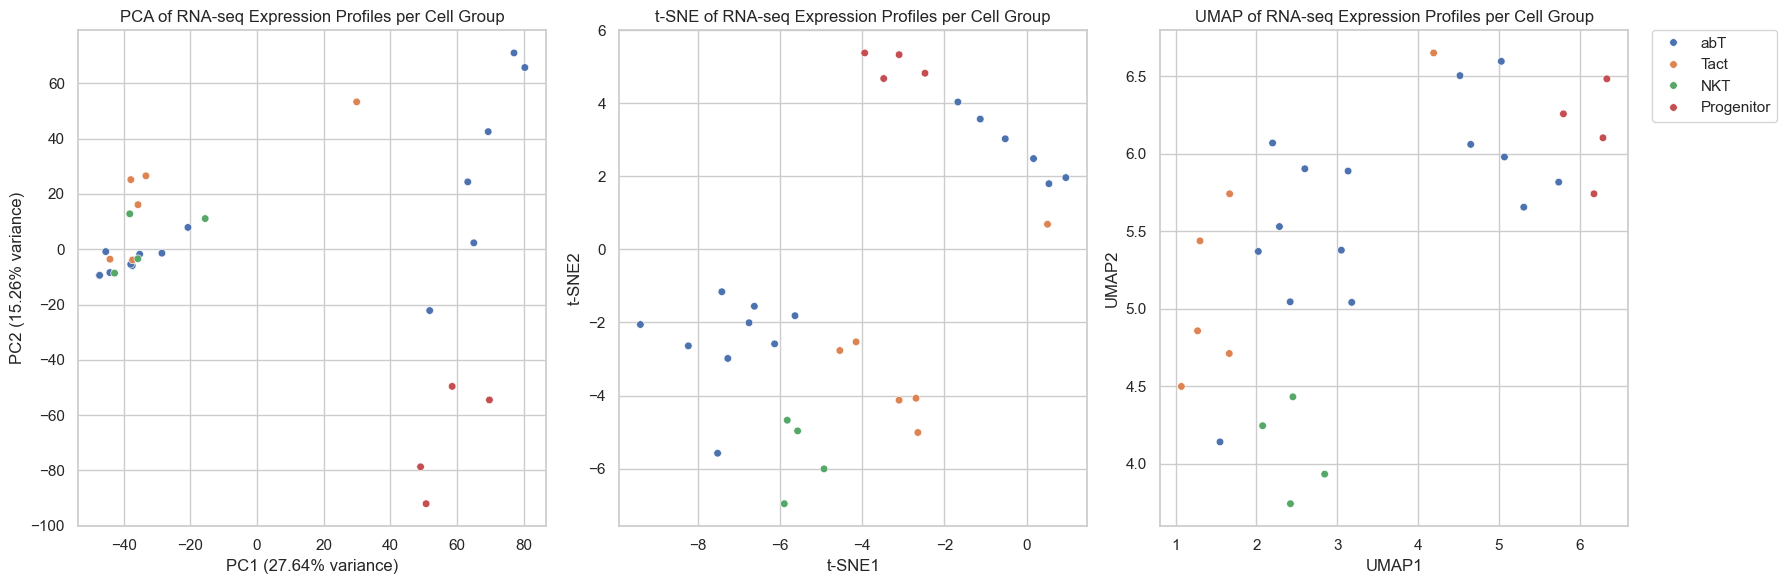

In [33]:
## PCA, UMAP, t-SNE of gene expression profiles per cell group
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Define cell type groups
abT_cells = [
    "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th", "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.8.Nve.Sp", "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co", "T8.TN.P14.Sp"
]
NKT_cells = [
    "NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d"
]
tact_cells = [
    "T.4.Sp.aCD3+CD40.18hr", "T8.TE.LCMV.d7.Sp", "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.Gut",
    "T8.Tcm.LCMV.d180.Sp", "T8.Tem.LCMV.d180.Sp"
]
stem_cells = [
    "LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"
]

# Create group mapping 
group_map = {}
for sample in abT_cells:
    group_map[sample] = "abT"
for sample in NKT_cells:
    group_map[sample] = "NKT"
for sample in tact_cells:
    group_map[sample] = "Tact"
for sample in stem_cells:
    group_map[sample] = "Progenitor"

# Set up the scaled and transposed expression data
rna_transposed = transposed_scaled_df  # rows = cell types, columns = genes

#  PCA 
rna_pca = PCA(n_components=2)
rna_pca_result = rna_pca.fit_transform(rna_transposed)
rna_pca_df = pd.DataFrame(rna_pca_result, columns=["PC1", "PC2"], index=rna_transposed.index)
rna_pca_df["Group"] = rna_pca_df.index.map(lambda name: group_map.get(name, "Other"))

#  t-SNE 
rna_tsne_model = TSNE(n_components=2, random_state=42, perplexity=10)
rna_tsne_result = rna_tsne_model.fit_transform(rna_transposed)
rna_tsne_df = pd.DataFrame(rna_tsne_result, columns=["t-SNE1", "t-SNE2"], index=rna_transposed.index)
rna_tsne_df["Group"] = rna_tsne_df.index.map(lambda name: group_map.get(name, "Other"))

#  UMAP 
rna_umap_model = umap.UMAP(n_components=2, random_state=42)
rna_umap_result = rna_umap_model.fit_transform(rna_transposed)
rna_umap_df = pd.DataFrame(rna_umap_result, columns=["UMAP1", "UMAP2"], index=rna_transposed.index)
rna_umap_df["Group"] = rna_umap_df.index.map(lambda name: group_map.get(name, "Other"))

#  Plotting 
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA
sns.scatterplot(
    data=rna_pca_df,
    x="PC1", y="PC2",
    hue="Group", s=30,
    ax=axes[0], legend=False
)
axes[0].set_title("PCA of RNA-seq Expression Profiles per Cell Group")
axes[0].set_xlabel(f"PC1 ({rna_pca.explained_variance_ratio_[0]*100:.2f}% variance)")
axes[0].set_ylabel(f"PC2 ({rna_pca.explained_variance_ratio_[1]*100:.2f}% variance)")

# t-SNE
sns.scatterplot(
    data=rna_tsne_df,
    x="t-SNE1", y="t-SNE2",
    hue="Group", s=30,
    ax=axes[1], legend=False
)
axes[1].set_title("t-SNE of RNA-seq Expression Profiles per Cell Group")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")

# UMAP
sns.scatterplot(
    data=rna_umap_df,
    x="UMAP1", y="UMAP2",
    hue="Group", s=30,
    ax=axes[2]
)
axes[2].set_title("UMAP of RNA-seq Expression Profiles per Cell Group")
axes[2].set_xlabel("UMAP1")
axes[2].set_ylabel("UMAP2")

# Move legend to the right of UMAP plot
axes[2].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()



**Fig. 3: Dimensionality reduction of RNA-seq expression profiles per cell group**

Clusters are much clearer in this graphs. Coloring by abT, Tact, NKT, Progenitor shows each group as a distinct island in all methods. The αβ T cells cluster tightly, while progenitor cells are far removed. NKT and Tact cell groups are intermediate and partially overlap with abT in t-SNE/UMAP but still distinct.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


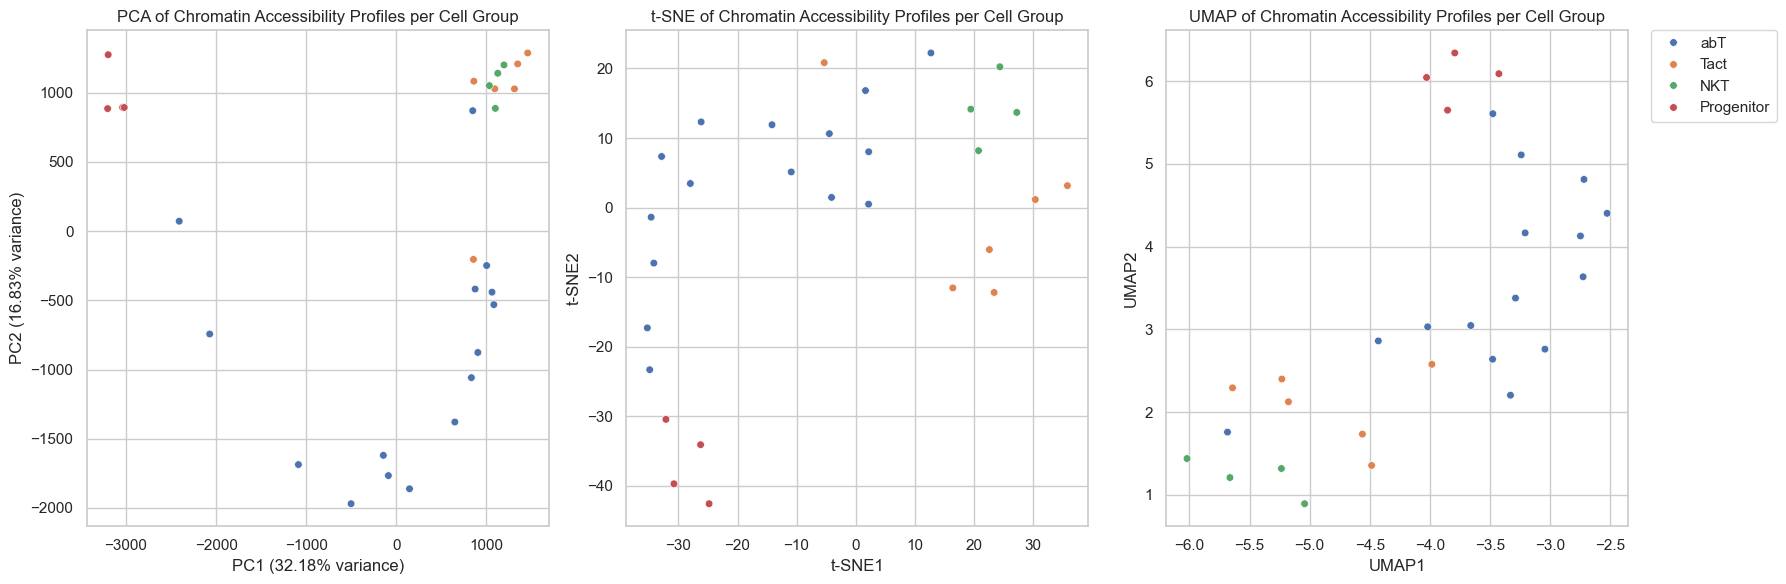

In [34]:
## PCA, UMAP, t-SNE of chromatin accessibility profiles per cell group
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Define cell type groups
abT_cells = [
    "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th", "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.8.Nve.Sp", "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co", "T8.TN.P14.Sp"
]
NKT_cells = [
    "NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d"
]
tact_cells = [
    "T.4.Sp.aCD3+CD40.18hr", "T8.TE.LCMV.d7.Sp", "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.SI",
    "T8.Tcm.LCMV.d180.Sp", "T8.Tem.LCMV.d180.Sp"
]
stem_cells = [
    "LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"
]

# Create group mapping 
group_map = {}
for sample in abT_cells:
    group_map[sample] = "abT"
for sample in NKT_cells:
    group_map[sample] = "NKT"
for sample in tact_cells:
    group_map[sample] = "Tact"
for sample in stem_cells:
    group_map[sample] = "Progenitor"

# Set up the scaled and transposed expression data
subset = atac_transposed

# --- PCA ---
atac_pca = PCA(n_components=2)
atac_pca_result = atac_pca.fit_transform(subset)
atac_pca_df = pd.DataFrame(atac_pca_result, columns=["PC1", "PC2"], index=subset.index)
atac_pca_df["Group"] = atac_pca_df.index.map(lambda name: group_map.get(name, "Other"))

# --- t-SNE ---
atac_tsne_model = TSNE(n_components=2, random_state=42, perplexity=10)
atac_tsne_result = atac_tsne_model.fit_transform(subset)
atac_tsne_df = pd.DataFrame(atac_tsne_result, columns=["t-SNE1", "t-SNE2"], index=subset.index)
atac_tsne_df["Group"] = atac_tsne_df.index.map(lambda name: group_map.get(name, "Other"))

# --- UMAP ---
atac_umap_model = umap.UMAP(n_components=2, random_state=42)
atac_umap_result = atac_umap_model.fit_transform(subset)
atac_umap_df = pd.DataFrame(atac_umap_result, columns=["UMAP1", "UMAP2"], index=subset.index)
atac_umap_df["Group"] = atac_umap_df.index.map(lambda name: group_map.get(name, "Other"))

# --- Plotting ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA
sns.scatterplot(
    data=atac_pca_df,
    x="PC1", y="PC2",
    hue="Group", s=30,
    ax=axes[0], legend=False
)
axes[0].set_title("PCA of Chromatin Accessibility Profiles per Cell Group")
axes[0].set_xlabel(f"PC1 ({atac_pca.explained_variance_ratio_[0]*100:.2f}% variance)")
axes[0].set_ylabel(f"PC2 ({atac_pca.explained_variance_ratio_[1]*100:.2f}% variance)")

# t-SNE
sns.scatterplot(
    data=atac_tsne_df,
    x="t-SNE1", y="t-SNE2",
    hue="Group", s=30,
    ax=axes[1], legend=False
)
axes[1].set_title("t-SNE of Chromatin Accessibility Profiles per Cell Group")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")

# UMAP
sns.scatterplot(
    data=atac_umap_df,
    x="UMAP1", y="UMAP2",
    hue="Group", s=30,
    ax=axes[2]
)
axes[2].set_title("UMAP of Chromatin Accessibility Profiles per Cell Group")
axes[2].set_xlabel("UMAP1")
axes[2].set_ylabel("UMAP2")

# Move legend to the right of UMAP plot
axes[2].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()



**Fig. 4: Dimensionality reduction of chromatin accessibility profiles across cell groups**

The chromatin accessibility progiles show even more extreme separation of progenitor and abT clusters in PCA which reflects major chromatin state changes with differentiation. Tact and NKT sometimes overlap or are adjacent, indicating similarity in accessibility, though still distinct from abT. Additionally, within-group variation is visible, even within progenitor cells, there is some spread, especially in UMAP.


### Comparison ATAC-seq chromatin accessibility and RNA-seq gene expression profiles
#### Comparing graphs

Comparing Fig. 1, 2, 3 and 4 we observe:

- for progenitor cells:
    
    Generally, in all four figures, the progenitor cells cluster distinctly from the rest, but in Fig. 4 PCA they are much farther from lymphoid cells than in Fig. 3 PCA. This suggests that the chromatin "ground state" is much more different from differentiated lymphoid cells than the transcriptome suggests.

- for NKT cells:
    
    In Fig. 2 & 4, NKT and LPS-activated NKT subtypes are more widely spread and sometimes intermediate between progenitor and abT clusters. This indicates that NKT activation triggers significant chromatin remodeling. Fig. 1 & 3 also show NKT cells clustering near each other, but they still remain relatively close to other T cells. 

- for abT and Tact cells:
    
    This two cell groups are clearly separated Fig. 2 & 4, but overlap slightly in Fig. 1 & 3, showing that ATAC-seq resolves regulatory differences between activated and resting T cells better than gene expression alone.

While comparing the graphs, we noticed that one of the names differed between the data sets, so we will check which one it is.

In [35]:
# Checking column names
rna_pca_df = rna_pca_df.reset_index().rename(columns={"index": "CellType"})
atac_pca_df = atac_pca_df.reset_index().rename(columns={"index": "CellType"})

RNA_seq = set(rna_pca_df["CellType"].unique())
ATAC_seq = set(atac_pca_df["CellType"].unique())

only_in_RNA_seq= RNA_seq - ATAC_seq
only_in_ATAC_seq = ATAC_seq - RNA_seq
in_both = RNA_seq & ATAC_seq

print("Values only in RNA_seq:", sorted(only_in_RNA_seq))
print("Values only in ATAC_seq:", sorted(only_in_ATAC_seq))
print("Common values:", sorted(in_both))

Values only in RNA_seq: ['T8.IEL.LCMV.d7.Gut']
Values only in ATAC_seq: ['T8.IEL.LCMV.d7.SI']
Common values: ['LTHSC.34+.BM', 'LTHSC.34-.BM', 'MPP4.135+.BM', 'NKT.Sp', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'NKT.Sp.LPS.3hr', 'STHSC.150-.BM', 'T.4.Nve.Fem.Sp', 'T.4.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.4.Th', 'T.8.Nve.Sp', 'T.8.Th', 'T.DN4.Th', 'T.DP.Th', 'T.ISP.Th', 'T8.MP.LCMV.d7.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.TN.P14.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th']


We can see that the names T8.IEL.LCMV.d7.Gut and T8.IEL.LCMV.d7.SI differ, but it's actually the same cell type just named differently, so we will fix that now.

In [36]:
# Standardize the cell type name in RNA-seq data to match ATAC-seq
rna_pca_df["CellType"] = rna_pca_df["CellType"].replace("T8.IEL.LCMV.d7.Gut", "T8.IEL.LCMV.d7.SI")
rna_pca_df["Group"] = rna_pca_df["Group"].replace("T8.IEL.LCMV.d7.Gut", "T8.IEL.LCMV.d7.SI")

#### Comparing via Spearman correlation

Now that we fixed this, we wanto to further compare the chromatin accessibility with the gene expression profiles using the Spearman correlation. 

Spearman correlation tells you how well the rank order (who is closest/farthest from whom) is preserved between two datasets — not the exact values, but the relative order of similarities/distances. Here, it ranks all the pairwise distances between cell types for both data types. Then it checks how similar these rankings are between RNA-seq and ATAC-seq. A high Spearman correlation (close to 1) means the most similar and most distinct pairs are largely the same in both spaces, a value of 0 would mean no relationship and a negative value that the relationships are reversed

In [37]:
# Spearman correlation for ATAC-seq and RNA-seq comparison (dimensionality reduction)

from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np

# Define dimension reduction methods and their column names
methods = {
    "PCA":    (rna_pca_df, atac_pca_df, ["PC1", "PC2"]),
    "UMAP":   (rna_umap_df, atac_umap_df, ["UMAP1", "UMAP2"]),
    "t-SNE":  (rna_tsne_df, atac_tsne_df, ["t-SNE1", "t-SNE2"]),
}

for method, (rna_df, atac_df, cols) in methods.items():
    # Ensure dataframes have same cell types and order
    common = rna_df.index.intersection(atac_df.index)
    rna = rna_df.loc[common, cols]
    atac = atac_df.loc[common, cols]

    # Compute pairwise distance matrices
    rna_dist = squareform(pdist(rna))
    atac_dist = squareform(pdist(atac))

    # Flatten to vectors (only upper triangle, excluding diagonal)
    rna_vec = rna_dist[np.triu_indices_from(rna_dist, k=1)]
    atac_vec = atac_dist[np.triu_indices_from(atac_dist, k=1)]

    # Spearman correlation
    corr, _ = spearmanr(rna_vec, atac_vec)
    print(f"Spearman correlation between {method} distance structures: {corr:.3f}")


Spearman correlation between PCA distance structures: 0.637
Spearman correlation between UMAP distance structures: 0.796
Spearman correlation between t-SNE distance structures: 0.684


We can see that the Spearman correlation values are overall pretty high which indicates that the relative similarity and difference among cell types is moderately well-preserved between the transcriptomic and chromatin accessibility landscapes. This suggests substantial agreement in global cell type relationships between data types, but also reveals biologically meaningful differences in how chromatin and expression define cell state similarity. The Spearman correlation is the highest for UMAP (0.796) between the distance structures of RNA-seq and ATAC-seq data. This means UMAP best preserves the biological relationships among cell types across both omics layers, making it the most consistent method for integrative visualization and comparison in this dataset.

## 2. Gene similarity matrix and chromatin similarity matrix

In this section, we want to compare the heatmaps for chromatin and gene similarity between cell types and cell groups. In the gene_expression_clustering.ipynb and ATAC_clustering_analysis.ipynb notebooks we did both a Pearson correlation and a Euclidean distance heatmap, we will compare them now.

### Euclidean distance heatmap per cell type

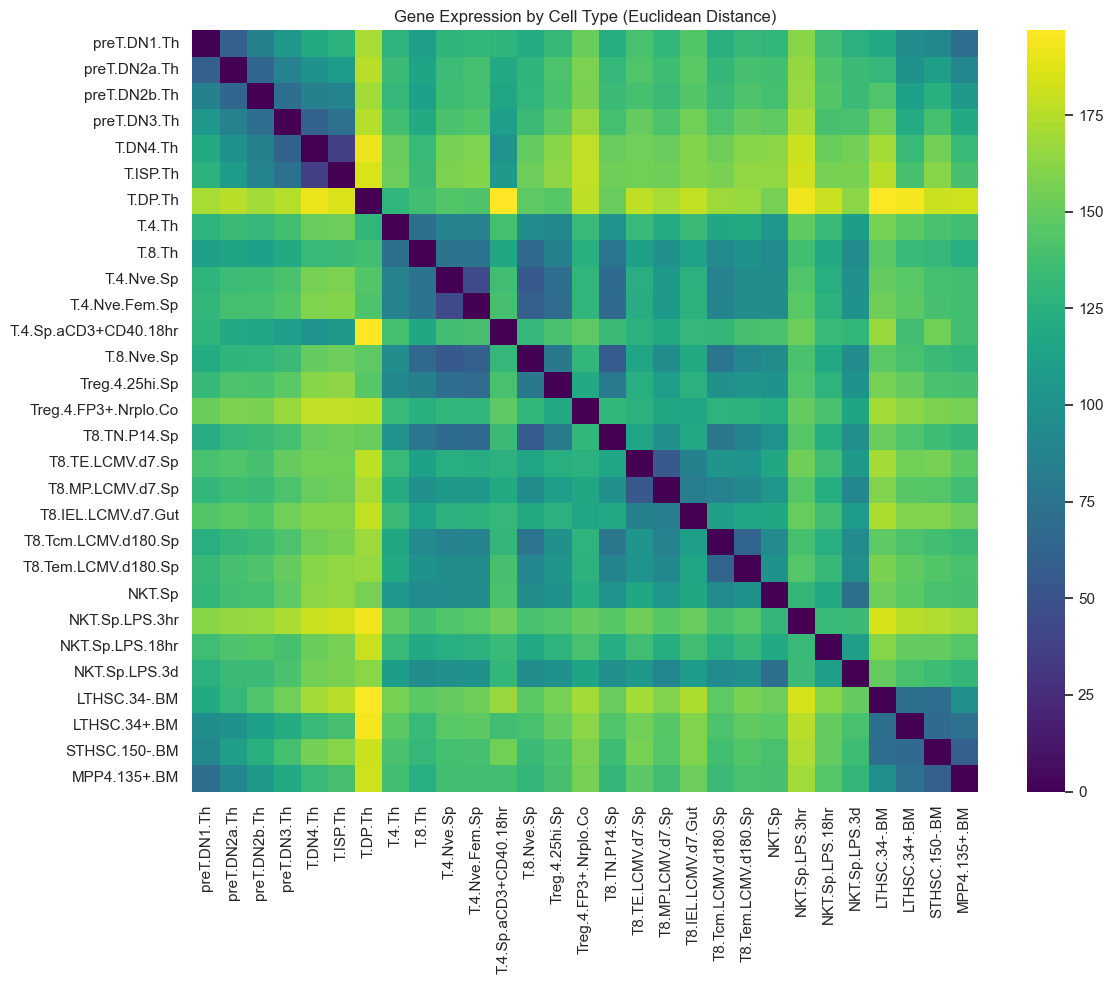

In [38]:
# Euclidean distance matrix for gene expression 

# Computing pairwise distance matrix (Euclidean distance between rows)
from scipy.spatial.distance import pdist, squareform
import pandas as pd

distance_matrix = pd.DataFrame(
    squareform(pdist(rna_transposed, metric='euclidean')),
    index=rna_transposed.index,
    columns=rna_transposed.index
)

## Plotting heatmap with sample names 
import seaborn as sns
import matplotlib.pyplot as plt

# For Euclidean distance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Gene Expression by Cell Type (Euclidean Distance)")
plt.tight_layout()
plt.show()


**Fig. 5: Gene expression Euclidean distance per cell type (Euclidean distance) - heatmap**

Progenitor cells have very high distances (lighter colors) from most T-cell populations. This means their chromatin accessibility is quite distinct from mature T cells. Pre-T cells are closer (darker squares) to each other, indicating greater similarity in their chromatin states during development. Effector/activated T cells tend to cluster together (darker regions) — their chromatin accessibility profiles are also quite similar.

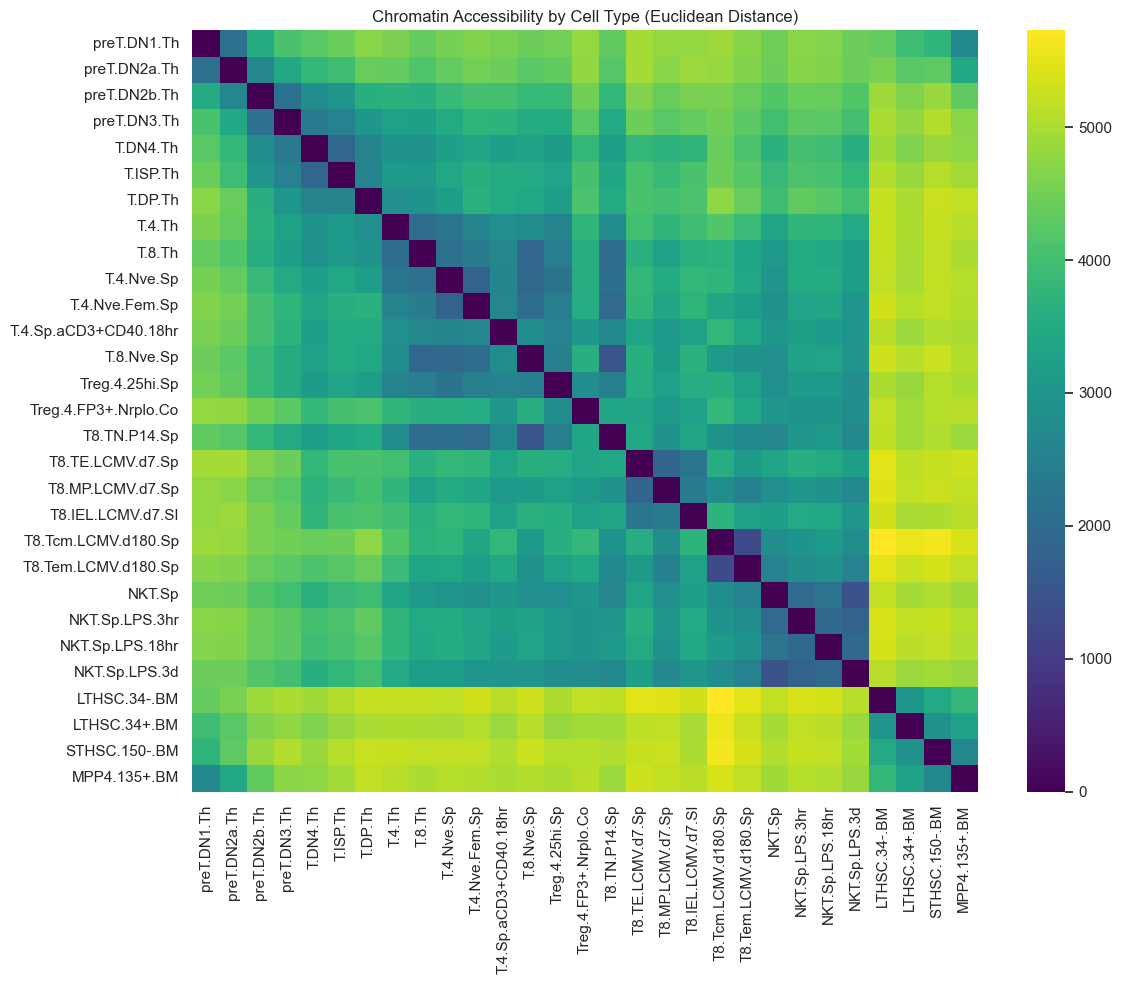

In [39]:
# Euclidean distance matrix for chromatin accessibility per cell type

# Computing pairwise distance matrix (Euclidean distance between rows)
from scipy.spatial.distance import pdist, squareform
import pandas as pd

distance_matrix = pd.DataFrame(
    squareform(pdist(atac_transposed, metric='euclidean')),
    index=atac_transposed.index,
    columns=atac_transposed.index
)

## Plotting heatmap with sample names 
import seaborn as sns
import matplotlib.pyplot as plt

# For Euclidean distance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Chromatin Accessibility by Cell Type (Euclidean Distance)")
plt.tight_layout()
plt.show()


**Fig. 6: Chromatin accessibility per cell type (Euclidean distance) - heatmap**

Progenitor cells again show the largest distances from T cells (lighter colors) — confirming that not only chromatin, but also transcriptional programs, are very different. Pre-T cell types show tight clustering (dark squares among themselves), indicating similar transcriptomes in early T cell development. Mature T cell subsets have relatively darker blocks between them, suggesting their gene expression is more similar to each other than to other cell types.

### Euclidean distance heatmap per cell group

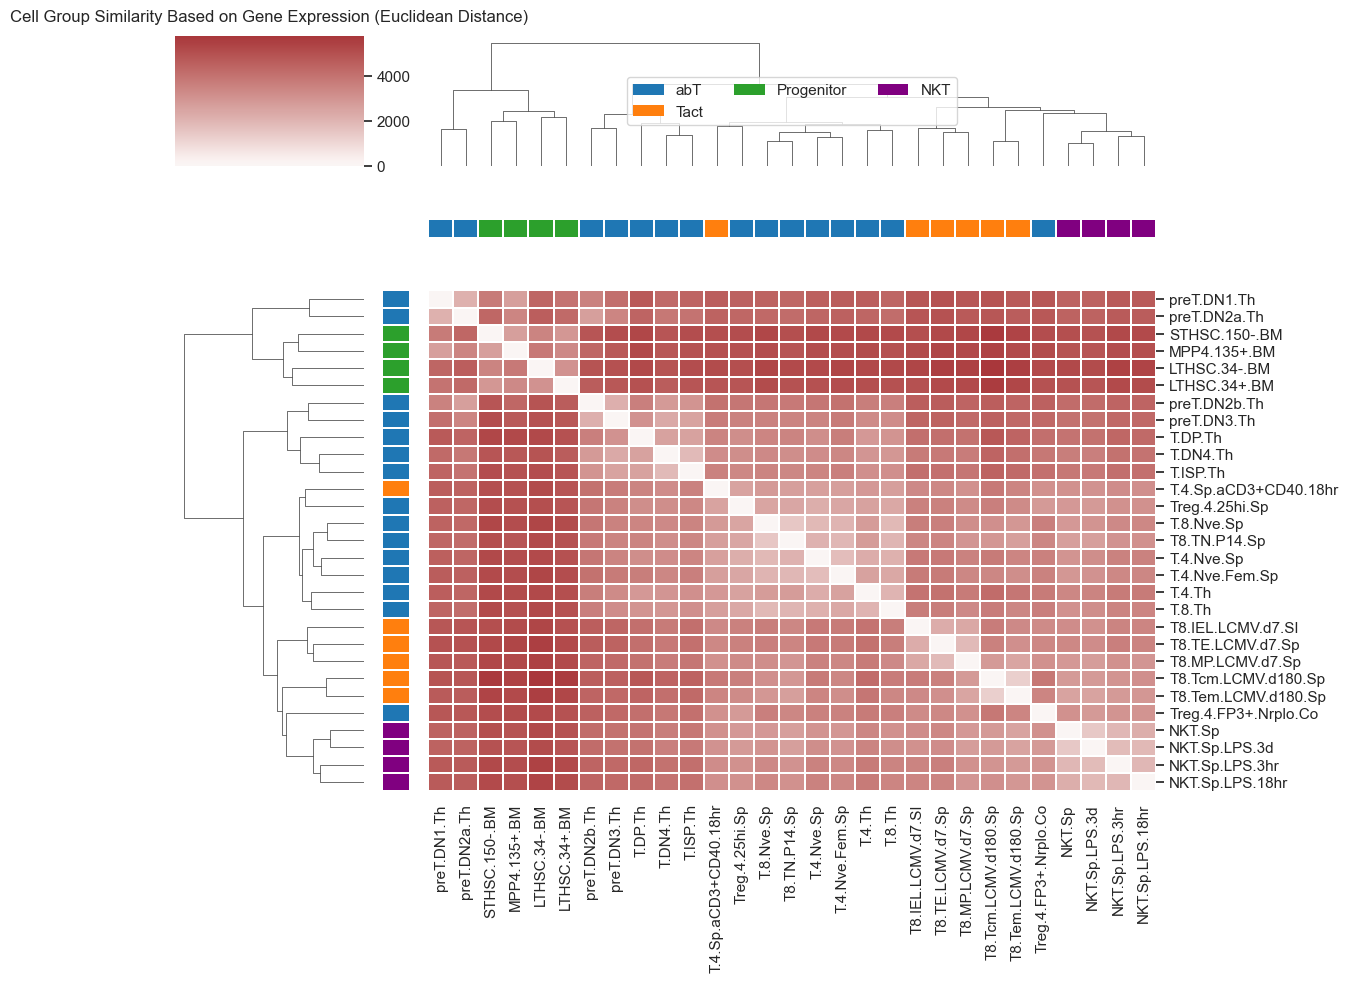

In [40]:
# Euclidean distance matrix on gene expression per cell groups (abT, NKT, Tact and progenitor)

## Preparing group mapping  
rna_pca_df = rna_pca_df.set_index("CellType")
group_series = rna_pca_df["Group"]

## Creating color palette for row labels
import seaborn as sns

group_palette = {
    "abT": "#1f77b4",      # blue
    "Tact": "#ff7f0e",     # orange
    "Progenitor": "#2ca02c",  # green
    "NKT" : "#800080" # purple
}

### Create a color list in the same order as distance_matrix rows
def safe_color(name):
    group = group_series.get(name, None)
    if pd.isnull(group) or group not in group_palette:
        return "#cccccc"  # fallback grey
    return group_palette[group]

row_colors = distance_matrix.index.map(safe_color)

## Plotting heatmap with colored labels
import seaborn as sns
import matplotlib.pyplot as plt

### For Euclidean distance_matrix
sns.set(style="white")
g = sns.clustermap(
    distance_matrix,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(12, 10),
    cmap="vlag",  
    center=0,
    linewidths=0.1
)

for label in group_palette:
    g.ax_col_dendrogram.bar(0, 0, color=group_palette[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=3)

plt.title("Cell Group Similarity Based on Gene Expression (Euclidean Distance)", y=1.05)
plt.tight_layout()
plt.show()

**Fig. 7: Cell group similarity based on gene expression (Euclidean distance)**

This heatmap reveals that cell types within the same functional group (abT, Tact, Progenitor, NKT) are more similar in their gene expression profiles, clustering together as indicated by lighter blocks along the diagonal. In contrast, different cell groups (e.g., abT vs Progenitor, or NKT vs Tact) show higher Euclidean distances, appearing as darker red blocks off the diagonal. The colored bars and dendrogram reinforce that group identity is a strong driver of gene expression similarity, with NKT and Progenitor groups forming especially tight internal clusters.

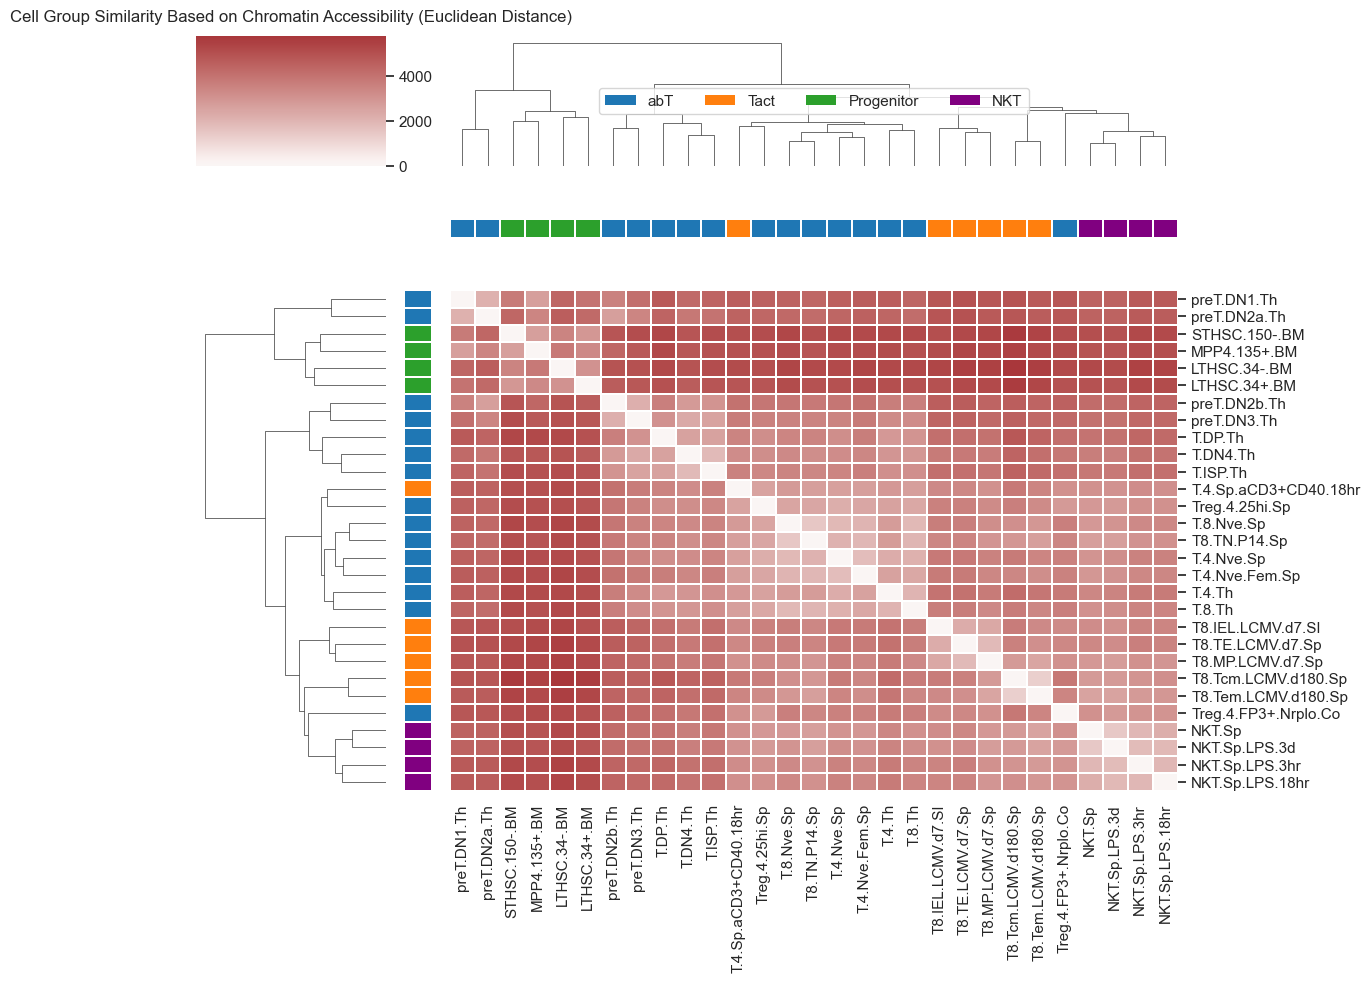

In [41]:
# Euclidean distance matrix on chromatin accessibility per cell groups (abT, NKT, Tact and progenitor)
# Make a dictionary from cell type to group
atac_pca_df = atac_pca_df.reset_index()
celltype_to_group = dict(zip(atac_pca_df["CellType"], atac_pca_df["Group"]))

# Update color function to use this mapping
def safe_color(name):
    group = celltype_to_group.get(name, None)
    if pd.isnull(group) or group not in group_palette:
        return "#cccccc"  # fallback grey
    return group_palette[group]

# Map colors for each row/column
row_colors = distance_matrix.index.map(safe_color)

# Plot heatmap
sns.set(style="white")
g = sns.clustermap(
    distance_matrix,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(12, 10),
    cmap="vlag",  
    center=0,
    linewidths=0.1
)

for label in group_palette:
    g.ax_col_dendrogram.bar(0, 0, color=group_palette[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=4)

plt.title("Cell Group Similarity Based on Chromatin Accessibility (Euclidean Distance)", y=1.05)
plt.tight_layout()
plt.show()


**Fig. 8: Cell group similarity based on chromatin accessibility profiles (Euclidean distance)**

we see similar cell types (same developmental lineage or function) tend to have similar chromatin landscapes. NKT (purple) and Progenitor (green) show the greatest difference, matching their very different biological roles. For example, all the abT cells (T cell development) are grouped together, and Progenitor (stem-like) cells are their own distinct cluster.

### Comparison chromatin accessibility and gene expression per Euclidean distance

The cell type structure is preserved in both chromatin and gene expression. Groups cluster together in both data types, showing that lineage identity is encoded in both modalities. For most cell types, the closest relatives by ATAC are also the closest by RNA-seq (e.g., NKT and abT intra-group), indicating a high degree of regulatory concordance.

NKT cells (purple) cluster together in both ATAC and RNA, showing distinct regulatory and expression programs. abT cells (blue) show tight clustering in both modalities; e.g., preT.DN1.Th and T.DP.Th are closer to each other than to any NKT or Progenitor cell.Progenitor cells (green) group tightly, showing their stem/progenitor state is distinct in both chromatin and expression. Tact cells (orange) separate from both abT and NKT, highlighting their unique activation state.

### Pearson correlation heatmap per cell types

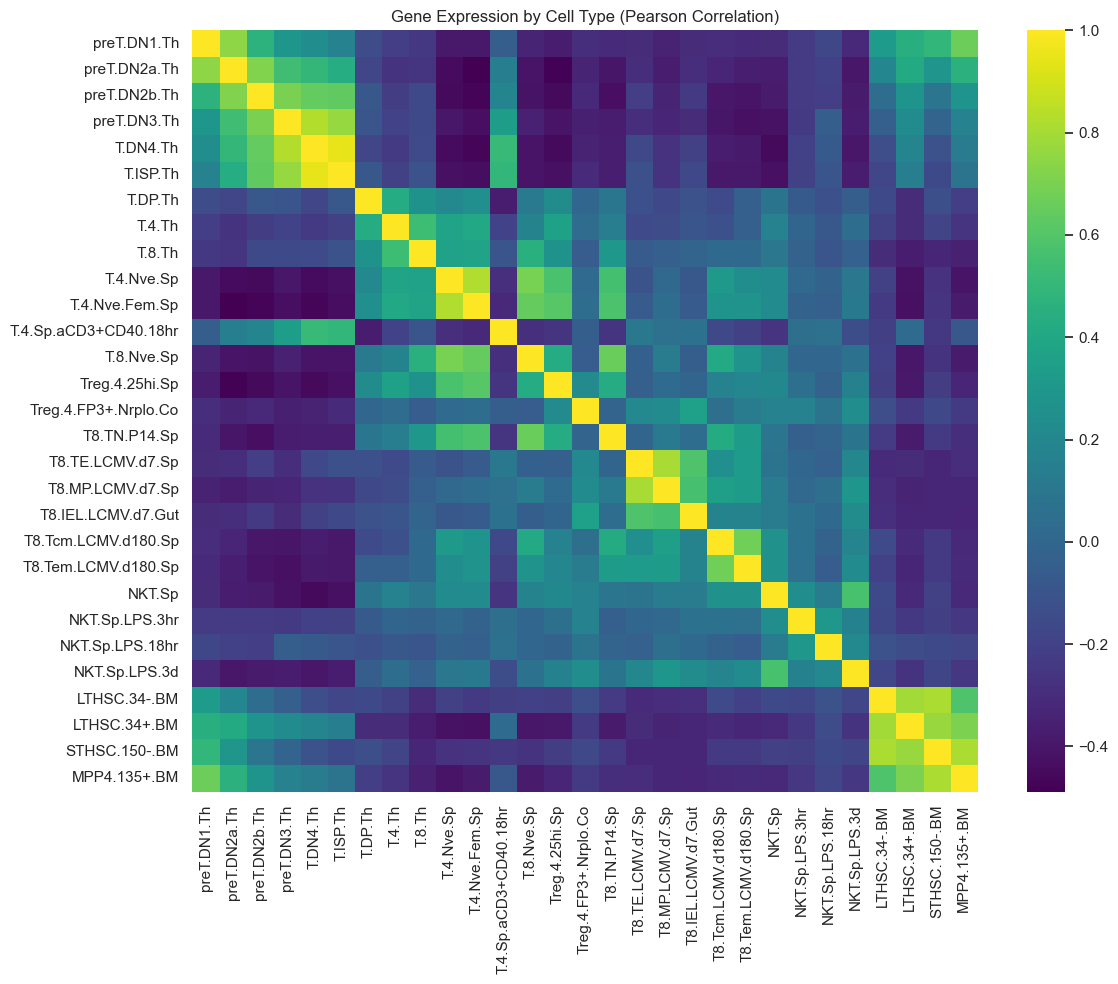

In [42]:
# Pearson correlation heatmap on gene expression

# Computing pairwise correlation matrix (Pearson correlation between samples)
correlation_matrix = transposed_scaled_df.T.corr()

## Plotting heatmap with sample names 
import seaborn as sns
import matplotlib.pyplot as plt

# For correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Gene Expression by Cell Type (Pearson Correlation)")
plt.tight_layout()
plt.show()

**Fig. 9: Gene expression by cell type (Pearson correlation)**

This heatmap allows us to visually identify which cell types are transcriptionally similar or distinct, matching biological expectations. For example, all pre-T cell stages cluster tightly together, while progenitors stand out as highly distinct. NKT and activated T cells show moderate similarity, highlighting their related but unique transcriptional programs.

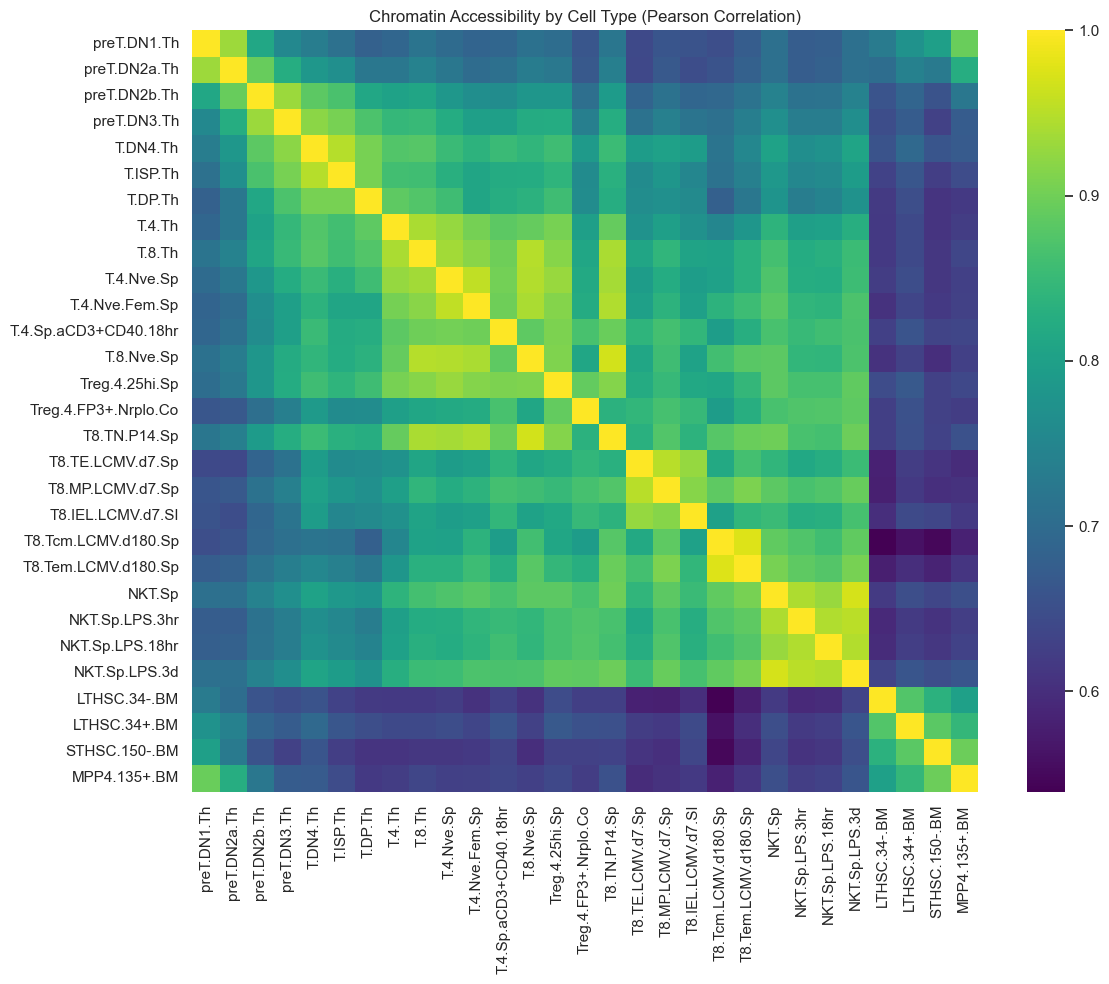

In [43]:
# Pearson correlation heatmap on chromatin accessibility

# Computing pairwise correlation matrix (Pearson correlation between samples)
correlation_matrix = atac_transposed.T.corr()

## Plotting heatmap with sample names 
import seaborn as sns
import matplotlib.pyplot as plt

# For correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Chromatin Accessibility by Cell Type (Pearson Correlation)")
plt.tight_layout()
plt.show()

**Fig. 10: Chromatin accessibility by cell type (Pearson correlation)**

This heatmap reveals that cell types with shared lineage or activation status have highly similar chromatin accessibility landscapes. For example, preT developmental stages cluster tightly together, while hematopoietic stem cells are clearly distinct. NKT cells form a distinct group, closely correlated within themselves, but less so with conventional T cells. This highlights both lineage fidelity and regulatory differences at the chromatin level.

#### Pearson correlation heatmap on cell groups

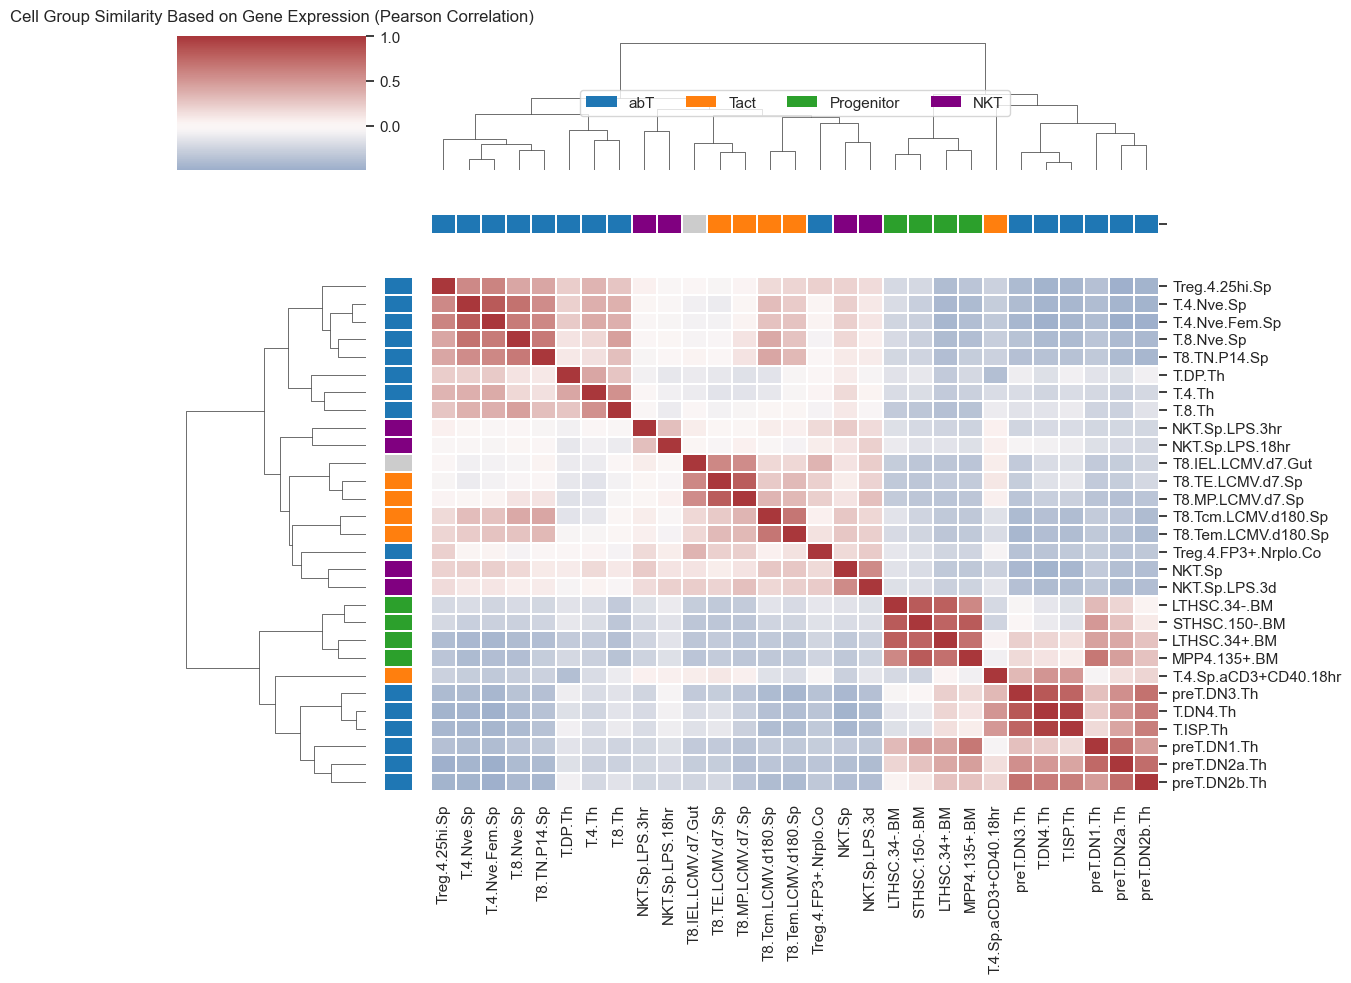

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = rna_transposed.T.corr()

# repare group information
group_series = rna_pca_df["Group"]  

# Define color palette
group_palette = {
    "abT": "#1f77b4",      # blue
    "Tact": "#ff7f0e",     # orange
    "Progenitor": "#2ca02c",  # green
    "NKT" : "#800080"        # purple
}

# Map cell types to group colors
def safe_color(celltype):
    group = group_series.get(celltype, None)
    return group_palette.get(group, "#cccccc")  

row_colors = pd.Series([safe_color(celltype) for celltype in correlation_matrix.index], index=correlation_matrix.index)


# 6. Plot the clustermap
sns.set(style="white")
g = sns.clustermap(
    correlation_matrix,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(12, 10),
    cmap="vlag",  
    center=0,
    linewidths=0.1
)

for label in group_palette:
    g.ax_col_dendrogram.bar(0, 0, color=group_palette[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=4)

plt.title("Cell Group Similarity Based on Gene Expression (Pearson Correlation)", y=1.05)
plt.tight_layout()
plt.show()


**Fig. 11: Cell group similarity based on gene expression (Pearson correlation)**

This clustermap shows how similar each pair of cell types is in terms of their global gene‐expression profiles, using Pearson correlation as the similarity metric.

The preT.DN1.Th vs. preT.DN2a.Th have a ρ ≈ 1.0 (brightest red) which shows nearly identical transcriptional states in sequential thymic stages. MPP4.135+.BM vs. LTHSC.34+.BM have a ρ > 0.95 which means that they have shared stem/progenitor identity in bone marrow. The NKT.Sp.LPS.3hr vs. other NKT or abT has a moderate correlation (ρ ≈ 0.65) with unstimulated NKT but lower (ρ ≈ 0.55) with progenitors, highlighting LPS‐induced changes. Additionally, the activated T cells (orange) often lie between naïve abT and NKT branches so it suggestst tha TCR engagement drives convergence across lineages. The weakest correlations (white‐to‐blue in the bottom right) occur between abT/Tact and progenitors (ρ ≈ 0.5–0.6), underscoring major developmental shifts.

In general, the primary drivers of clustering are lineage (progenitor → thymic → peripheral) and then activation state (naïve vs. effector). The Pearson‐based clustering reveals conserved gene modules within each group (deep red blocks). Further, the intermixing of Tact and NKT cells with abT subsets shows that activation can override lineage boundaries, producing similar transcriptional signatures across different T-cell types.  

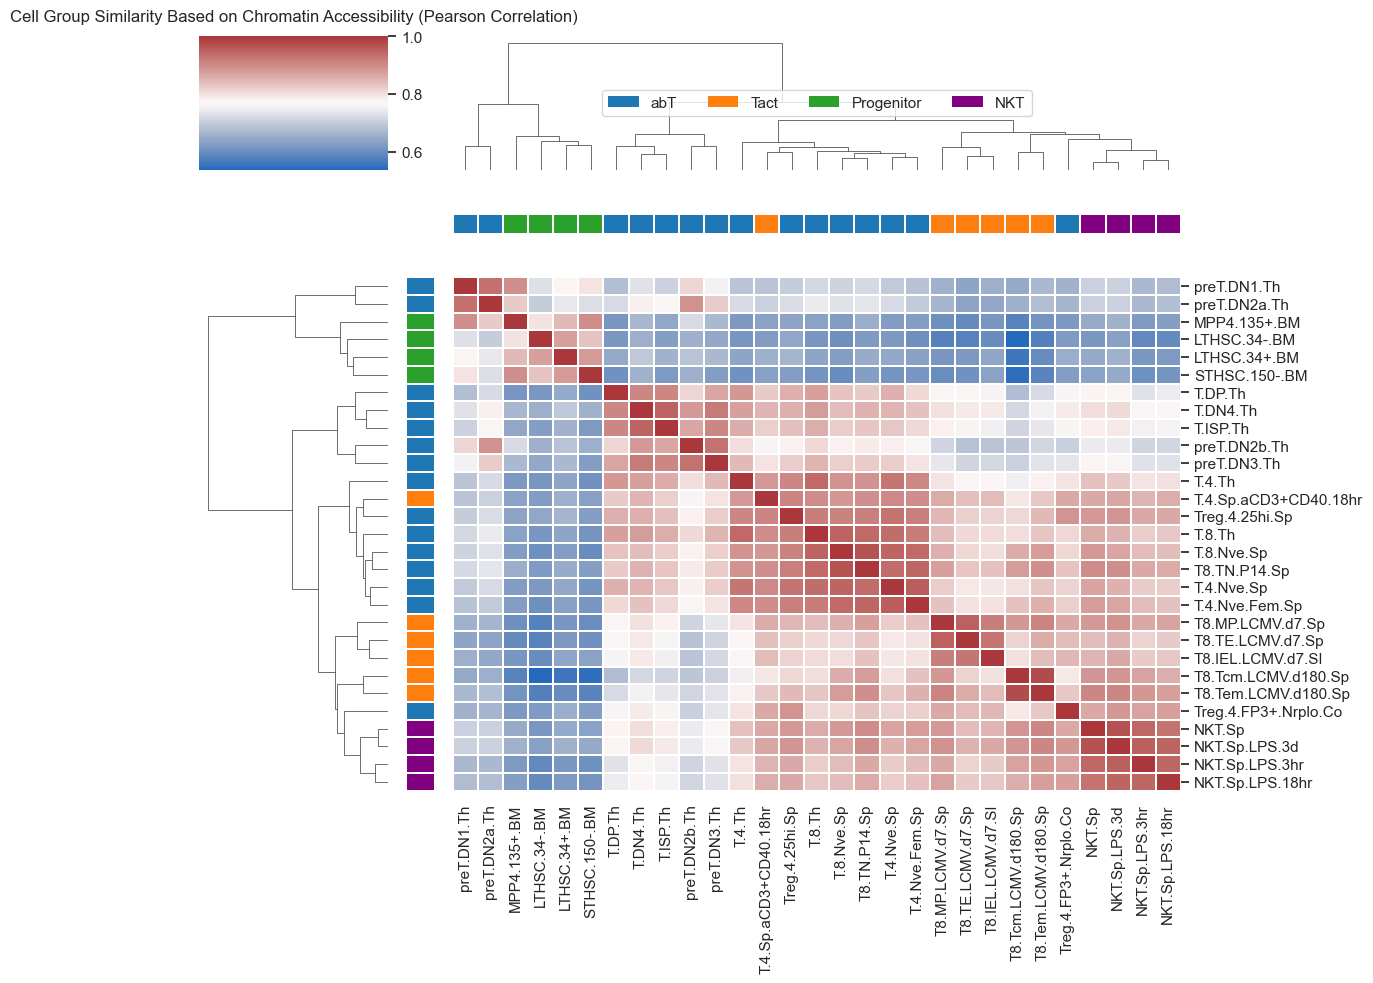

In [45]:
# Pearson correlation on chromatin accessibiity by cell groups 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix on chromatin accessibility 
correlation_matrix = atac_transposed.T.corr()

# Prepare group info, using cell type names as index
if "CellType" in atac_pca_df.columns:
    atac_pca_df = atac_pca_df.set_index("CellType")

# Get group assignments
group_series = atac_pca_df["Group"]

# Align correlation matrix and group info
common = correlation_matrix.index.intersection(group_series.index)
correlation_matrix = correlation_matrix.loc[common, common]
group_series = group_series.loc[common]

# Map group to colors
group_palette = {
    "abT": "#1f77b4",      # blue
    "Tact": "#ff7f0e",     # orange
    "Progenitor": "#2ca02c",  # green
    "NKT": "#800080"        # purple
}

row_colors = correlation_matrix.index.map(group_series).map(group_palette).fillna("#cccccc")

# Plot clustermap
sns.set(style="white")
g = sns.clustermap(
    correlation_matrix,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(12, 10),
    cmap="vlag",
    linewidths=0.1
)

for label in group_palette:
    g.ax_col_dendrogram.bar(0, 0, color=group_palette[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=len(group_palette))

plt.title("Cell Group Similarity Based on Chromatin Accessibility (Pearson Correlation)", y=1.05)
plt.tight_layout()
plt.show()


**Fig. 12: Cell group similarity based on chromatin accessibility (Pearson correlation)**

Tact and NKT branches sit between naïve T and progenitor clusters, showing that stimulus-driven remodeling can override developmental distance. The lowest correlations (<0.6, pale blue) occur between stem/progenitor and mature/activated T cells, highlighting large chromatin rewiring from HSC to peripheral lymphocytes. Within peripheral T cells, memory subsets (e.g. `T8.MP.LCMV.d7.Sp`) correlate more strongly with each other (ρ ≈ 0.9) than with naïve subsets (ρ ≈ 0.8), reflecting subtle accessibility shifts that underpin immunological memory.

Chromatin accessibility recapitulates the same broad lineage and activation patterns seen in RNA-seq, but often with sharper separation between progenitors and lymphoid states. Peaks of highest correlation (deep red blocks) correspond to shared regulatory elements in each developmental or activation stage. Regions of intermediate correlation (warm‐to‐cool tones) point to transitional or mixed epigenetic states, meriting deeper investigation of the underlying cis-regulatory changes. Overall, Pearson‐based clustering of ATAC-seq data confirms that both lineage commitment and activation imprint distinct and reproducible chromatin signatures across these cell types. 

#### Comparison chromatin accessibility and gene expression per Pearson correlation

Pearson correlation on RNA highlights directional differences in expression—negative correlations appear when two cell types adopt opposing programs. Pearson correlation on ATAC tends to stay positive, since many regulatory regions remain accessible even as expression diverges. Cell-type heatmaps resolve fine developmental or activation trajectories, whereas cell-group heatmaps summarize those patterns at a coarser level.

For example, in Fig. 11 preT.DN1.Th vs. preT.DN2a.Th correlate at ρ ≈ 0.92 (bright yellow), reflecting a gradual transition in their transcriptomes. In Fig. 12 the same pair shows ρ ≈ 0.98 (even more saturated yellow), indicating their chromatin landscapes change even more smoothly and remain almost identical. The progenitor cells (LTHSC.34-.BM vs. MPP4.135+.BM) correlate around ρ ≈ 0.75 (green) in Fig. 11, reflecting a shared stem-cell transcriptional signature. In contrast, their chromatin profiles are nearly identical at ρ ≈ 0.97 (bright yellow), showing that most enhancers remain open throughout the HSC→MPP transition. The NKT cells barely correlate in Fig. 11 (ρ ≈ 0.05, deep purple), because transcription swings rapidly. Yet their chromatin remains largely stable at ρ ≈ 0.70 (green), implying that accessibility changes lag behind transcriptional bursts.

#### Comparing via Spearman correlation

In [46]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# Spearman on Euclidean distances in PCA space 

# Indexe the same way
common = rna_pca_df.index.intersection(atac_pca_df.index)
rna_pca = rna_pca_df.loc[common, ["PC1","PC2"]]
atac_pca = atac_pca_df.loc[common, ["PC1","PC2"]]

# Pairwise Euclidean
rna_dist = squareform(pdist(rna_pca.values))
atac_dist = squareform(pdist(atac_pca.values))

# Flatten upper triangles
iu = np.triu_indices_from(rna_dist, k=1)
rna_vec = rna_dist[iu]
atac_vec = atac_dist[iu]

# Spearman
rho_dist, p_dist = spearmanr(rna_vec, atac_vec)
print(f"Euclidean distances → Spearman ρ = {rho_dist:.3f}, p = {p_dist:.2g}")


# Spearman on Pearson correlation matrices

# Compute Pearson r matrices
rna_corr = rna_transposed.T.corr()
atac_corr = atac_transposed.T.corr()

# Align to same set & order of samples
common = rna_corr.index.intersection(atac_corr.index)
rna_corr = rna_corr.loc[common, common]
atac_corr = atac_corr.loc[common, common]

# Flatten upper triangles
mat = rna_corr.values
iu = np.triu_indices_from(mat, k=1)
rna_corr_vec  = mat[iu]
atac_corr_vec = atac_corr.values[iu]

# Spearman
rho_corr, p_corr = spearmanr(rna_corr_vec, atac_corr_vec)
print(f"Pearson‐matrix entries → Spearman ρ = {rho_corr:.3f}, p = {p_corr:.2g}")


Euclidean distances → Spearman ρ = 0.637, p = 1.3e-47
Pearson‐matrix entries → Spearman ρ = 0.590, p = 8e-37


We can see that the Spearman correlation coefficient is higher for the Euclidean distance matrix meaning that it portrays the relation between chromatin accessibility and gene expression levels better that the Pearson correlation. A value of ρ = 0.637 shows a generally positive correlation.

## 3. Peak clustering and gene clustering

Now, we want to compare the k-means clustering betweent the peaks and the genes.

### K-means clustering on cells

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


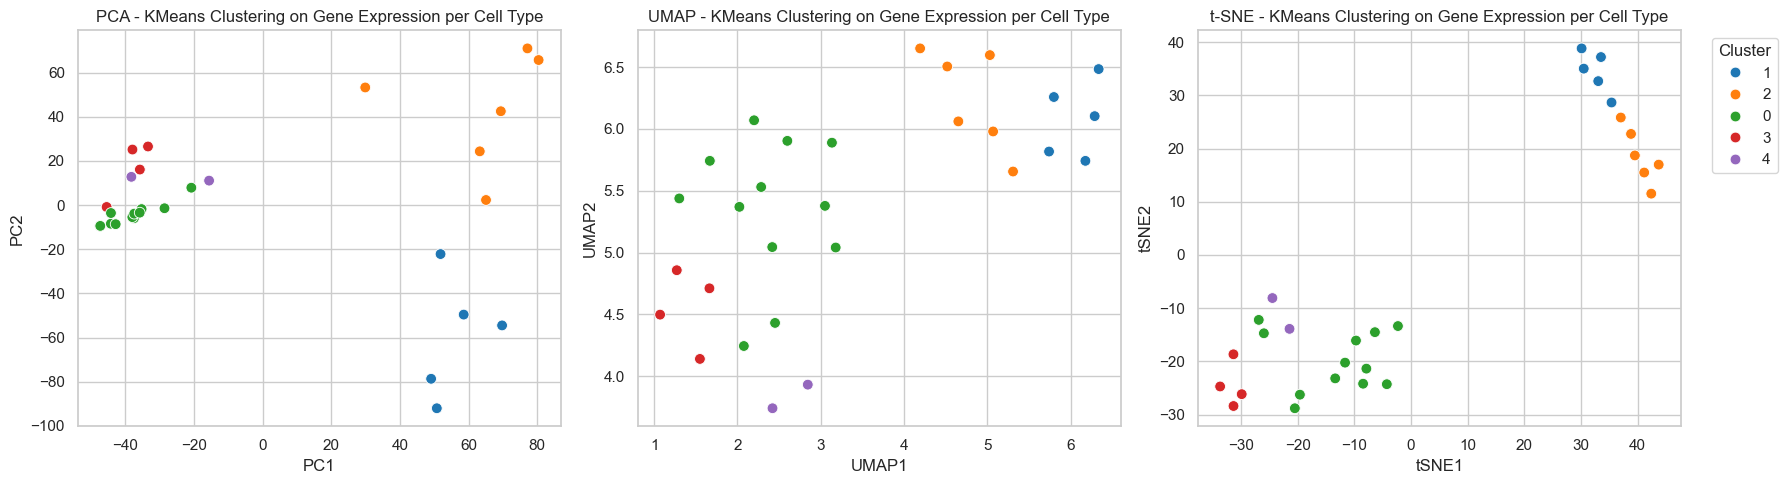

In [47]:
# Running k-means clustering on cell types (gene expression) 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP


# Loading dataset
df = rna_transposed

# Standardizing features
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# K-Means clustering (k=5) 
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Re-grouping cell subtypes into bigger cellular families
abT_cells = ["preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th","T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "T8.TN.P14.Sp"]

NKT_cells = ["NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d"]

tact_cells = ["T.4.Sp.aCD3+CD40.18hr",
    "T8.TE.LCMV.d7.Sp",
    "T8.MP.LCMV.d7.Sp",
    "T8.IEL.LCMV.d7.Gut",
    "T8.Tcm.LCMV.d180.Sp",
    "T8.Tem.LCMV.d180.Sp"]

stem_cells = [ "LTHSC.34-.BM", "LTHSC.34+.BM",
    "STHSC.150-.BM", "MPP4.135+.BM"]

# Mapping each cell to its group
group_map = {}

for sample in abT_cells:
    group_map[sample] = "abT"
for sample in NKT_cells:
    group_map[sample] = "NKT"
for sample in tact_cells:
    group_map[sample] = "Tact"
for sample in stem_cells:
    group_map[sample] = "Progenitor"


# Building a results DataFrame
results_rna = pd.DataFrame(index=df.index)
results_rna["Cluster"] = labels.astype(str)
results_rna["Group"]   = results_rna.index.map(lambda s: group_map.get(s, "Other"))

# Dimensionality reduction 
# PCA
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X)
results_rna["PC1"], results_rna["PC2"] = coords_pca[:, 0], coords_pca[:, 1]

# UMAP
umap = UMAP(n_components=2, random_state=42)
coords_umap = umap.fit_transform(X)
results_rna["UMAP1"], results_rna["UMAP2"] = coords_umap[:, 0], coords_umap[:, 1]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords_tsne = tsne.fit_transform(X)
results_rna["tSNE1"], results_rna["tSNE2"] = coords_tsne[:, 0], coords_tsne[:, 1]

# Plotting side-by-side 
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(
    data=results_rna, x="PC1", y="PC2",
    hue="Cluster", palette="tab10", s=60, ax=axes[0]
)
axes[0].set_title("PCA - KMeans Clustering on Gene Expression per Cell Type")

sns.scatterplot(
    data=results_rna, x="UMAP1", y="UMAP2",
    hue="Cluster", palette="tab10", s=60, ax=axes[1]
)
axes[1].set_title("UMAP - KMeans Clustering on Gene Expression per Cell Type")

sns.scatterplot(
    data=results_rna, x="tSNE1", y="tSNE2",
    hue="Cluster", palette="tab10", s=60, ax=axes[2]
)
axes[2].set_title("t-SNE - KMeans Clustering on Gene Expression per Cell Type")

# Clean up legends
for ax in axes:
    ax.legend_.remove()
axes[2].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


**Fig. 13: PCA, UMAP, t-SNE of k-means clustering on gene expression per cell type**

In [48]:
# Adding biological Group into results
results_rna["Group"] = results_rna.index.map(lambda s: group_map.get(s, "Other"))

# Cross-tabulate Cluster vs Group
ct = pd.crosstab(
    results_rna["Cluster"],
    results_rna["Group"],
    rownames=["KMeans Cluster"],
    colnames=["Biological Group"]
)
print(ct)

Biological Group  NKT  Progenitor  Tact  abT
KMeans Cluster                              
0                   2           0     2    8
1                   0           4     0    1
2                   0           0     1    5
3                   0           0     3    1
4                   2           0     0    0


c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


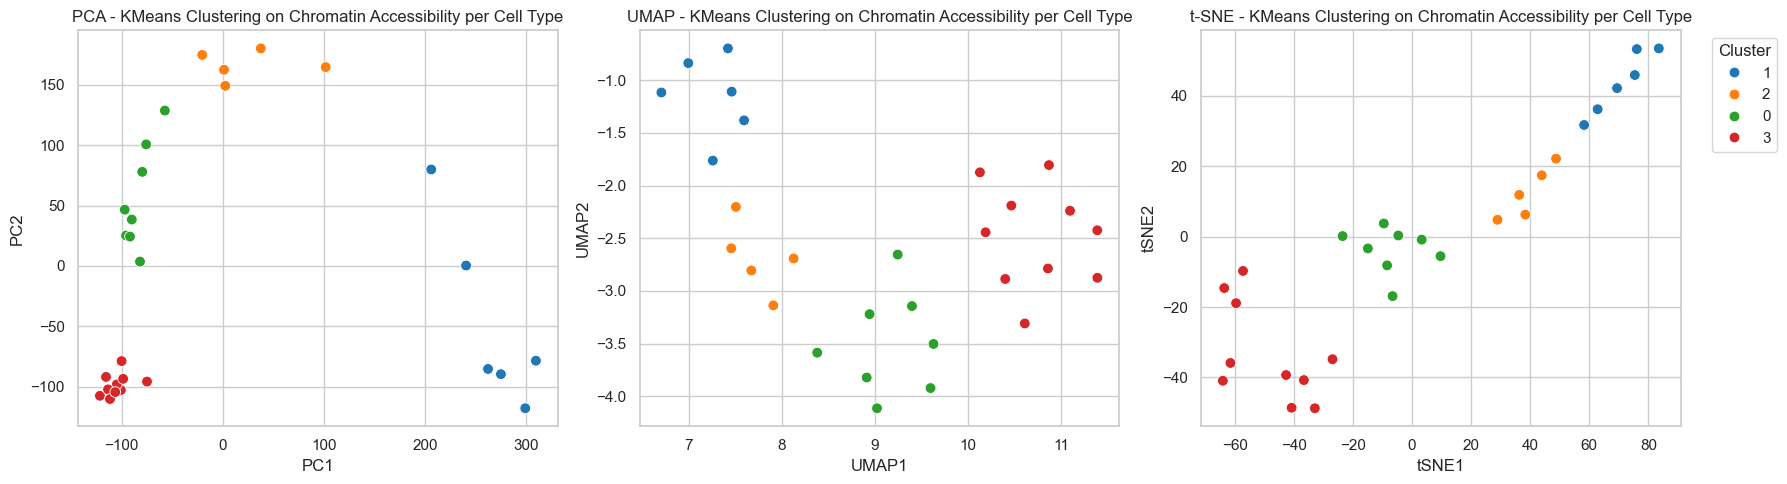

In [49]:
# Running k-means clustering on cell types (chromatin accessibility) 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP


# Loading dataset
df = atac_transposed

# Standardizing features
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# K-Means clustering (k=4) 
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Re-grouping cell subtypes into bigger cellular families
abT_cells = ["preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th","T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "T8.TN.P14.Sp"]

NKT_cells = ["NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d"]

tact_cells = ["T.4.Sp.aCD3+CD40.18hr",
    "T8.TE.LCMV.d7.Sp",
    "T8.MP.LCMV.d7.Sp",
    "T8.IEL.LCMV.d7.SI",
    "T8.Tcm.LCMV.d180.Sp",
    "T8.Tem.LCMV.d180.Sp"]

stem_cells = [ "LTHSC.34-.BM", "LTHSC.34+.BM",
    "STHSC.150-.BM", "MPP4.135+.BM"]

# Mapping each cell to its group
group_map = {}

for sample in abT_cells:
    group_map[sample] = "abT"
for sample in NKT_cells:
    group_map[sample] = "NKT"
for sample in tact_cells:
    group_map[sample] = "Tact"
for sample in stem_cells:
    group_map[sample] = "Progenitor"


# Building a results DataFrame
results_atac = pd.DataFrame(index=df.index)
results_atac["Cluster"] = labels.astype(str)
results_atac["Group"]   = results_atac.index.map(lambda s: group_map.get(s, "Other"))

# Dimensionality reduction 
# PCA
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X)
results_atac["PC1"], results_atac["PC2"] = coords_pca[:, 0], coords_pca[:, 1]

# UMAP
umap = UMAP(n_components=2, random_state=42)
coords_umap = umap.fit_transform(X)
results_atac["UMAP1"], results_atac["UMAP2"] = coords_umap[:, 0], coords_umap[:, 1]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords_tsne = tsne.fit_transform(X)
results_atac["tSNE1"], results_atac["tSNE2"] = coords_tsne[:, 0], coords_tsne[:, 1]

# Plotting side-by-side 
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(
    data=results_atac, x="PC1", y="PC2",
    hue="Cluster", palette="tab10", s=60, ax=axes[0]
)
axes[0].set_title("PCA - KMeans Clustering on Chromatin Accessibility per Cell Type")

sns.scatterplot(
    data=results_atac, x="UMAP1", y="UMAP2",
    hue="Cluster", palette="tab10", s=60, ax=axes[1]
)
axes[1].set_title("UMAP - KMeans Clustering on Chromatin Accessibility per Cell Type")

sns.scatterplot(
    data=results_atac, x="tSNE1", y="tSNE2",
    hue="Cluster", palette="tab10", s=60, ax=axes[2]
)
axes[2].set_title("t-SNE - KMeans Clustering on Chromatin Accessibility per Cell Type")

# Clean up legends
for ax in axes:
    ax.legend_.remove()
axes[2].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


**Fig. 14: PCA, UMAP, t-SNE k-means clustering of chromatin accessibility per cellt types**

In [50]:
# Adding biological Group into results
results_atac["Group"] = results_atac.index.map(lambda s: group_map.get(s, "Other"))

# Cross-tabulate Cluster vs Group
ct = pd.crosstab(
    results_atac["Cluster"],
    results_atac["Group"],
    rownames=["KMeans Cluster"],
    colnames=["Biological Group"]
)
print(ct)

Biological Group  NKT  Progenitor  Tact  abT
KMeans Cluster                              
0                   0           0     1    7
1                   0           4     0    2
2                   0           0     0    5
3                   4           0     5    1


#### K-means clustering on peaks and genes

In [51]:
# Transpose back gene expression matrix
refined_df.head()

preT.DN1.Th  preT.DN2a.Th  preT.DN2b.Th  preT.DN3.Th  \
0610007P14Rik   162.641117    206.945221    209.187788   198.421365   
0610009B22Rik    68.070719     82.468806     89.769337    57.661619   
0610009O20Rik   160.246297    125.475307    155.928005   120.692893   
0610010F05Rik   155.767862    273.998186    154.269870   129.834226   
0610010K14Rik   146.959609    166.023337    245.243593   225.662176   

                 T.DN4.Th    T.ISP.Th    T.DP.Th      T.4.Th      T.8.Th  \
0610007P14Rik  215.056475  225.565360  73.904647  138.841383  139.863904   
0610009B22Rik   76.399214   84.671456  32.828651   27.207241   36.169759   
0610009O20Rik  118.433597  149.630866  92.040668   76.781112   87.529814   
0610010F05Rik  197.843435  173.726109  58.203391   42.950719   26.099208   
0610010K14Rik  252.196726  245.295957  84.157303  204.219996  198.168772   

               T.4.Nve.Sp  ...  T8.Tcm.LCMV.d180.Sp  T8.Tem.LCMV.d180.Sp  \
0610007P14Rik  168.924363  ...           206.241084           205.309922   
0610009B22Rik   32.753248  ...            36.105700            34.348965   
0610009O20Rik   86.523573  ...            87.608325            56.128251   
0610010F05Rik   40.183229  ...            29.771841            71.347412   
0610010K14Rik  199.553377  ...           184.547689           175.993310   

                   NKT.Sp  NKT.Sp.LPS.3hr  NKT.Sp.LPS.18hr  NKT.Sp.LPS.3d  \
0610007P14Rik  165.690720      133.234920       127.894194     195.147548   
0610009B22Rik   25.168975       33.305724        29.284365      33.322384   
0610009O20Rik  109.175415       91.992319       102.035627     108.414405   
0610010F05Rik   35.723998       11.660369        27.574347      54.965951   
0610010K14Rik  110.913976      137.817664       132.083765     123.633828   

               LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  
0610007P14Rik    206.053987    246.105317     192.424636    204.298358  
0610009B22Rik     78.272059     78.837030      68.844751     76.418169  
0610009O20Rik    168.645852    157.926022     155.941641    186.261464  
0610010F05Rik     75.934142    172.175681     119.156447    174.554003  
0610010K14Rik    149.566205    201.786082     155.028950    160.824830  

[5 rows x 29 columns]

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


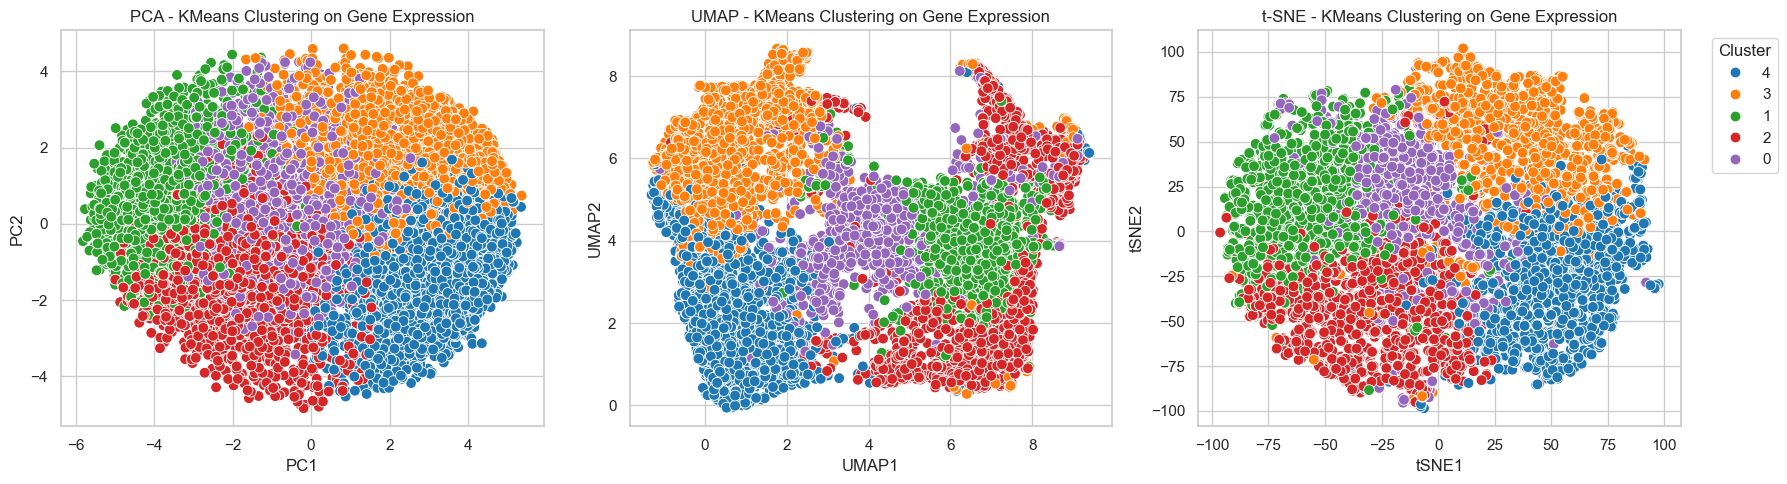

In [52]:
# Running k-means clustering on genes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Load refined data
df = refined_df.copy()

# Row-scale 
df = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

# Standardize features (columns) 
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# K-Means clustering (k=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Build results DataFrame
results_genes = pd.DataFrame(index=df.index)
results_genes["Cluster"] = labels.astype(str)

# Dimensionality reduction
#    PCA
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X)
results_genes["PC1"], results_genes["PC2"] = coords_pca[:, 0], coords_pca[:, 1]

#    UMAP
umap = UMAP(n_components=2, random_state=42)
coords_umap = umap.fit_transform(X)
results_genes["UMAP1"], results_genes["UMAP2"] = coords_umap[:, 0], coords_umap[:, 1]

#    t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords_tsne = tsne.fit_transform(X)
results_genes["tSNE1"], results_genes["tSNE2"] = coords_tsne[:, 0], coords_tsne[:, 1]

# Plotting side-by-side
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(
    data=results_genes, x="PC1", y="PC2",
    hue="Cluster", palette="tab10", s=60, ax=axes[0]
)
axes[0].set_title("PCA - KMeans Clustering on Gene Expression")

sns.scatterplot(
    data=results_genes, x="UMAP1", y="UMAP2",
    hue="Cluster", palette="tab10", s=60, ax=axes[1]
)
axes[1].set_title("UMAP - KMeans Clustering on Gene Expression")

sns.scatterplot(
    data=results_genes, x="tSNE1", y="tSNE2",
    hue="Cluster", palette="tab10", s=60, ax=axes[2]
)
axes[2].set_title("t-SNE - KMeans Clustering on Gene Expression")

# Clean up legends
for ax in axes:
    ax.legend_.remove()
axes[2].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


**Fig. 15: K-means clustering on gene expression**

In [53]:
# Adding biological Group into results
results_genes["Group"] = results_genes.index.map(lambda s: group_map.get(s, "Number of genes"))

# Cross-tabulate Cluster vs Group
ct = pd.crosstab(
    results_genes["Cluster"],
    results_genes["Group"],
    rownames=["KMeans Cluster"],
    colnames=["Type"]
)
print(ct)

Type            Number of genes
KMeans Cluster                 
0                          1139
1                          1621
2                          1885
3                          1778
4                          2071


c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


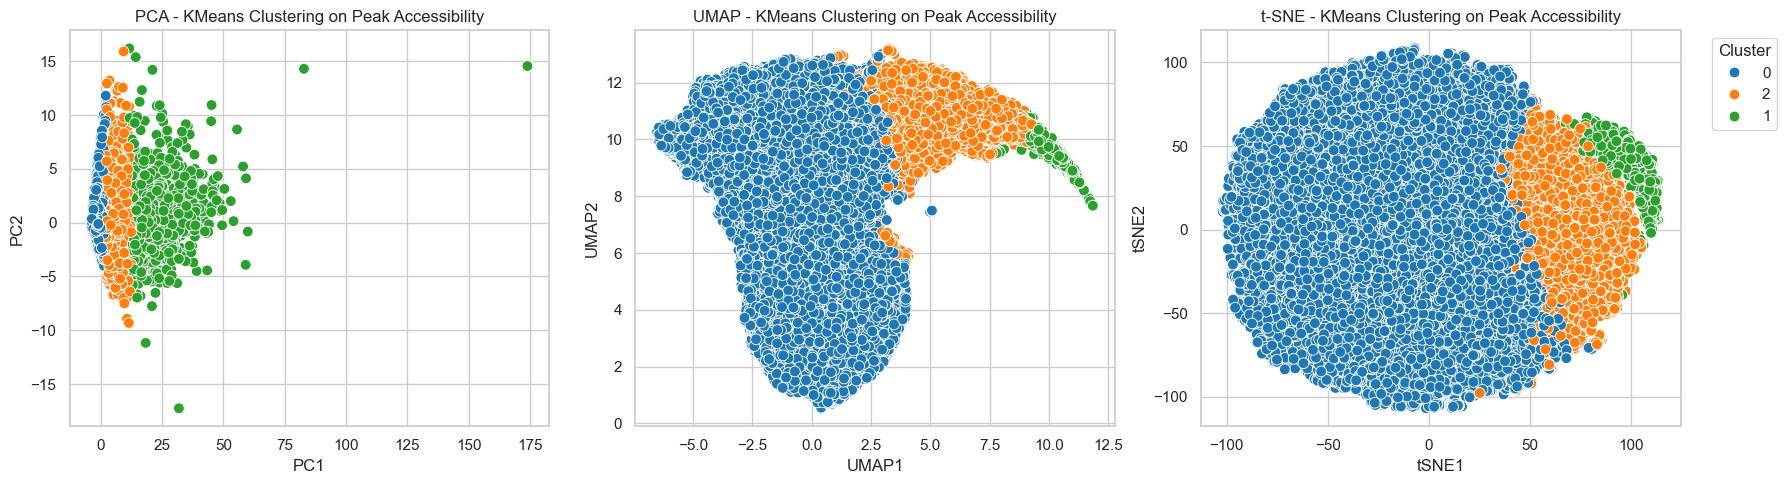

In [54]:
# Running k-means clustering on peaks
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP


# Loading dataset
df = signal_matrix

# Standardizing features
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# K-Means clustering (k=3) 
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Building  a results DataFrame
results_peaks = pd.DataFrame(index=df.index)
results_peaks["Cluster"] = labels.astype(str)

# Dimensionality reduction 
# PCA
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X)
results_peaks["PC1"], results_peaks["PC2"] = coords_pca[:, 0], coords_pca[:, 1]

# UMAP
umap = UMAP(n_components=2, random_state=42)
coords_umap = umap.fit_transform(X)
results_peaks["UMAP1"], results_peaks["UMAP2"] = coords_umap[:, 0], coords_umap[:, 1]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords_tsne = tsne.fit_transform(X)
results_peaks["tSNE1"], results_peaks["tSNE2"] = coords_tsne[:, 0], coords_tsne[:, 1]

# Plotting side-by-side 
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(
    data=results_peaks, x="PC1", y="PC2",
    hue="Cluster", palette="tab10", s=60, ax=axes[0]
)
axes[0].set_title("PCA - KMeans Clustering on Peak Accessibility")

sns.scatterplot(
    data=results_peaks, x="UMAP1", y="UMAP2",
    hue="Cluster", palette="tab10", s=60, ax=axes[1]
)
axes[1].set_title("UMAP - KMeans Clustering on Peak Accessibility")

sns.scatterplot(
    data=results_peaks, x="tSNE1", y="tSNE2",
    hue="Cluster", palette="tab10", s=60, ax=axes[2]
)
axes[2].set_title("t-SNE - KMeans Clustering on Peak Accessibility")

# Clean up legends
for ax in axes:
    ax.legend_.remove()
axes[2].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


**Fig. 16: K-means clustering on peak accessibility**

In [55]:
# Adding biological Group into results
results_peaks["Group"] = results_peaks.index.map(lambda s: group_map.get(s, "Number of peaks"))

# Cross-tabulate Cluster vs Group
ct = pd.crosstab(
    results_peaks["Cluster"],
    results_peaks["Group"],
    rownames=["KMeans Cluster"],
    colnames=["Type"]
)
print(ct)

Type            Number of peaks
KMeans Cluster                 
0                         61608
1                          2311
2                         11938


## Combine ATAC + RNA data

#### Canonical Correlation Analysis (CAA)

The Canonical Correlation Analysis (CAA) is a statistical method for finding relationships between two sets of variables, in this case between gene expression and peak accessibility. Essentially, we are asking the question: What linear combinations of the gene expression dataset and the peak accessibility dataset are most strongly correlated with each other?

We will be using it to find shared signals between the ATAC-seq and RNA-seq for the cells. The result will tell us which features (gene or peaks) drive the shared structure. 

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\

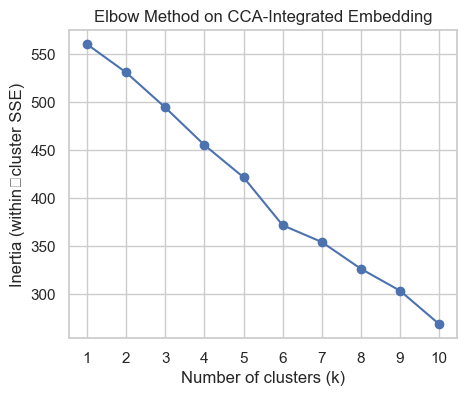

In [56]:
# Elbow method for finding optimal k for CCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.cluster import KMeans
from umap import UMAP

# Loading the two data‐matrices: rows=cells/samples, cols=features
expr_df = rna_transposed
acc_df = atac_transposed

# Standardize features and run PCA separately on each modality
# Gene-expression PCA
expr_scaled = StandardScaler().fit_transform(expr_df.values)
pca_expr    = PCA(n_components=20, random_state=42)
expr_pcs    = pca_expr.fit_transform(expr_scaled)

# Peak-accessibility PCA
acc_scaled = StandardScaler().fit_transform(acc_df.values)
pca_acc    = PCA(n_components=20, random_state=42)
acc_pcs    = pca_acc.fit_transform(acc_scaled)

# CCA: find shared components between the two PC spaces
n_cca = 10
cca   = CCA(n_components=n_cca, max_iter=1000)
expr_c, acc_c = cca.fit_transform(expr_pcs, acc_pcs)

# Stack the two CCA projections into one joint embedding
joint_cca = np.hstack([expr_c, acc_c])   # shape = (n_cells, 2*n_cca)

# Compute inertia for k = 1…10
ks       = range(1, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(joint_cca)
    inertias.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5,4))
plt.plot(ks, inertias, marker='o')
plt.xticks(ks)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within‐cluster SSE)")
plt.title("Elbow Method on CCA-Integrated Embedding")
plt.grid(True)
plt.show()

**Fig. 17: Elbow method for finding optimal k for CCA**

The graph isn't very conclusive, but there is a slight curve at k = 6, so we will take 6 to be the optimal number of cluters.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


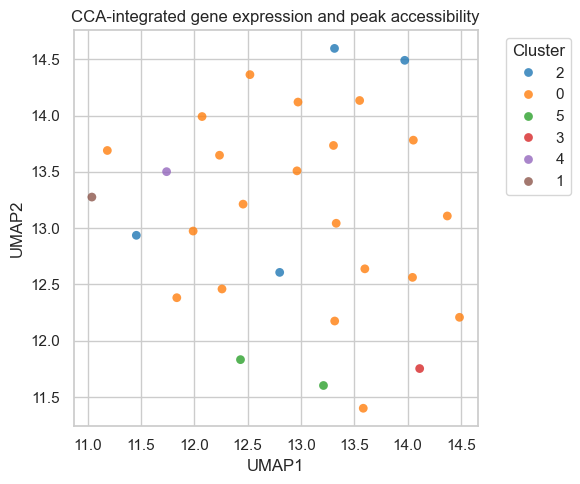

In [57]:
# CCA on gene expression and peak accessibility
# Cluster in the joint CCA space
n_clusters = 6
kmeans     = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
labels     = kmeans.fit_predict(joint_cca).astype(str)

# Non‐linear embedding (UMAP) of the joint CCA space for visualization
umap2d = UMAP(n_components=2, random_state=42)
coords = umap2d.fit_transform(joint_cca)

# Build results DataFrame and plot
results_rna_atac = pd.DataFrame(index=expr_df.index)
results_rna_atac["Cluster"] = labels
results_rna_atac["UMAP1"], results_rna_atac["UMAP2"] = coords[:,0], coords[:,1]

sns.set(style="whitegrid")
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=results_rna_atac,
    x="UMAP1", y="UMAP2",
    hue="Cluster", palette="tab10", s=40, linewidth=0, alpha=0.8
)
plt.title("CCA-integrated gene expression and peak accessibility")
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

**Fig. 18: CCA-integrated gene expression and peak accessibiity**

What we did here was take the gene-expression PCA and the accessibility PCA, ran CCA to find axes that both data types share and we then concatenated those CCA coordinates into a single high-dimensional representation of each cell. 

Points of the same color share a similar combination of expression and accessibility patterns. Most of the colors are cleanly separated which means they represent more distinct cell states.  

In [58]:
# Adding biological Group into results
group_map["T8.IEL.LCMV.d7.Gut"] = "Tact"       

results_rna_atac["Group"] = (
    results_rna_atac.index.map(lambda s: group_map.get(s, "Other"))
)

# Cross-tabulate Cluster vs Group
ct = pd.crosstab(
    results_rna_atac["Cluster"],
    results_rna_atac["Group"],
    rownames=["KMeans Cluster"],
    colnames=["Biological Group"]
)
print(ct)

Biological Group  NKT  Progenitor  Tact  abT
KMeans Cluster                              
0                   3           1     6   10
1                   0           1     0    0
2                   0           1     0    3
3                   1           0     0    0
4                   0           1     0    0
5                   0           0     0    2


We want to try to visualise it using a different method. To be able to work more easily we will import and rename the dataset again.

In [59]:
import pandas as pd

rna = pd.read_csv("filtered_RNA_abT_Tact_Stem.csv", index_col=0)


print(rna.columns)
print(rna.shape)
rna.head()

Index(['preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp',
       'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp',
       'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.Gut',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM',
       'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM'],
      dtype='object')
(17535, 29)


preT.DN1.Th  preT.DN2a.Th  preT.DN2b.Th  preT.DN3.Th  \
0610005C13Rik     1.022363      1.389747      1.024819     1.024482   
0610007P14Rik   162.641117    206.945221    209.187788   198.421365   
0610009B22Rik    68.070719     82.468806     89.769337    57.661619   
0610009L18Rik    15.450717     13.573968     14.427620     8.249482   
0610009O20Rik   160.246297    125.475307    155.928005   120.692893   

                 T.DN4.Th    T.ISP.Th    T.DP.Th      T.4.Th      T.8.Th  \
0610005C13Rik    1.026430    1.026217   3.010920    1.024462    1.024819   
0610007P14Rik  215.056475  225.565360  73.904647  138.841383  139.863904   
0610009B22Rik   76.399214   84.671456  32.828651   27.207241   36.169759   
0610009L18Rik    1.683173    4.001953   5.595954    6.367369    6.505833   
0610009O20Rik  118.433597  149.630866  92.040668   76.781112   87.529814   

               T.4.Nve.Sp  ...  T8.Tcm.LCMV.d180.Sp  T8.Tem.LCMV.d180.Sp  \
0610005C13Rik    2.726341  ...             1.025833             1.024819   
0610007P14Rik  168.924363  ...           206.241084           205.309922   
0610009B22Rik   32.753248  ...            36.105700            34.348965   
0610009L18Rik    8.262234  ...             8.645607             7.268431   
0610009O20Rik   86.523573  ...            87.608325            56.128251   

                   NKT.Sp  NKT.Sp.LPS.3hr  NKT.Sp.LPS.18hr  NKT.Sp.LPS.3d  \
0610005C13Rik    1.385805        1.025833         1.575395       1.024819   
0610007P14Rik  165.690720      133.234920       127.894194     195.147548   
0610009B22Rik   25.168975       33.305724        29.284365      33.322384   
0610009L18Rik    3.840215        1.025833         6.283540      12.791348   
0610009O20Rik  109.175415       91.992319       102.035627     108.414405   

               LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  
0610005C13Rik      1.096732      1.096732       1.021750      1.021812  
0610007P14Rik    206.053987    246.105317     192.424636    204.298358  
0610009B22Rik     78.272059     78.837030      68.844751     76.418169  
0610009L18Rik      8.577159     16.791386      15.511549     16.947354  
0610009O20Rik    168.645852    157.926022     155.941641    186.261464  

[5 rows x 29 columns]

In [60]:
print(signal_matrix.columns)
print(signal_matrix.shape)
signal_matrix.head()

Index(['preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp',
       'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp',
       'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM',
       'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM'],
      dtype='object')
(75857, 29)


preT.DN1.Th  preT.DN2a.Th  preT.DN2b.Th  preT.DN3.Th  T.DN4.Th  T.ISP.Th  \
0        14.81         22.31          5.17         2.00      3.54      5.53   
1        59.36         43.17         50.58        28.94      4.62      3.33   
2        40.73         28.06         12.60        30.46     14.85     13.72   
3        23.05          8.10          8.83        13.55      8.17      7.60   
4        20.15          7.29          2.67         3.08      2.89      1.54   

   T.DP.Th  T.4.Th  T.8.Th  T.4.Nve.Sp  ...  T8.Tcm.LCMV.d180.Sp  \
0     1.99    1.42    1.52        4.37  ...                 2.76   
1     1.09    1.76    3.20        1.89  ...                 2.66   
2     2.33   24.05   20.89       19.84  ...                58.49   
3     4.62   12.30    8.91       13.70  ...                28.85   
4     2.49    0.11    0.53        1.25  ...                 2.60   

   T8.Tem.LCMV.d180.Sp  NKT.Sp  NKT.Sp.LPS.3hr  NKT.Sp.LPS.18hr  \
0                 5.94    0.98            2.75             2.85   
1                 4.29    1.16            1.54             1.19   
2                41.12   25.50           18.36            16.14   
3                23.94   12.37            9.06            10.64   
4                 1.07    7.23            3.46             1.20   

   NKT.Sp.LPS.3d  LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  
0           1.49          0.41          2.57           3.52          7.89  
1           2.18          9.93          8.79          16.02         47.78  
2          19.20         36.48         28.99          26.03         33.68  
3           9.17         16.15         16.66          17.12         17.28  
4           5.36          0.41          0.71           2.69          5.80  

[5 rows x 29 columns]

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\

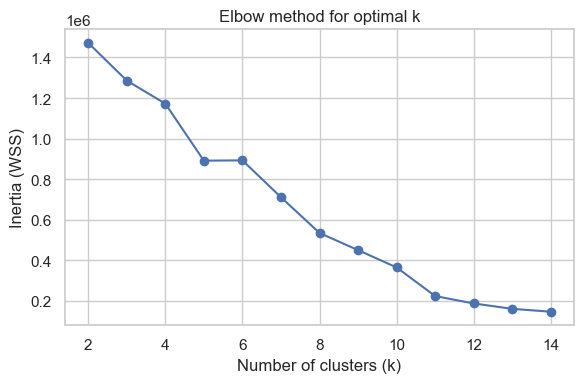

In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

# Load & reshape
rna = pd.read_csv("filtered_RNA_abT_Tact_Stem.csv").drop(columns=["Unnamed: 0"])
rna_t = rna.T                              

peak = signal_matrix

peak_t = peak.T                          

# Normalize
scaler = StandardScaler(with_mean=True, with_std=True)
rna_scaled  = scaler.fit_transform(rna_t)
peak_scaled = scaler.fit_transform(peak_t)

# PCA
pca_rna  = PCA(n_components=10).fit_transform(rna_scaled)
pca_peak = PCA(n_components=10).fit_transform(peak_scaled)

# Concatenate embeddings
X = np.hstack([pca_rna, pca_peak])

# Plot Elbow method

inertias = []
K_range = range(2, 15) 

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WSS)")
plt.title("Elbow method for optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()


We are choosing k=5 for further clustering.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


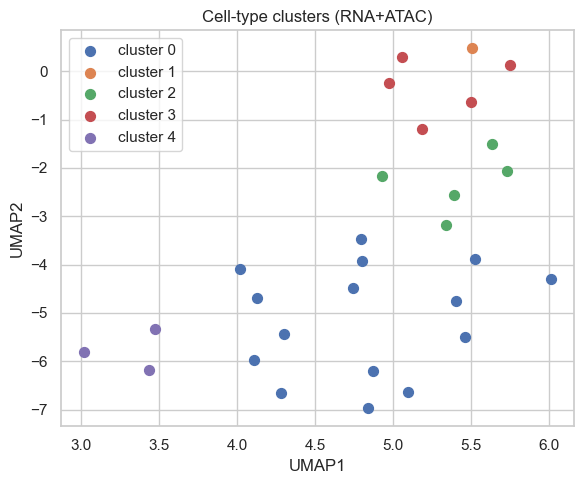

In [62]:
from sklearn.cluster import KMeans

# Clustering
n_clusters = 5
km = KMeans(n_clusters=n_clusters, random_state=0)
clusters_raw = km.fit_predict(X)

# attach back to a DataFrame for easy plotting
embed_df_raw = pd.DataFrame(
    umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=0)
      .fit_transform(X),
    index=rna_t.index,
    columns=["UMAP1", "UMAP2"]
)
embed_df_raw["cluster"] = clusters_raw

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
for c in np.unique(clusters_raw):
    idx = embed_df_raw["cluster"] == c
    plt.scatter(embed_df_raw.loc[idx,"UMAP1"],
                embed_df_raw.loc[idx,"UMAP2"],
                label=f"cluster {c}", s=50)
plt.legend()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Cell-type clusters (RNA+ATAC)")
plt.tight_layout()
plt.show()

In [63]:
cluster_to_cells = (
    embed_df_raw
    .groupby("cluster")
    .apply(lambda df: list(df.index))
    .to_dict()
)

for cl, cells in cluster_to_cells.items():
    print(f"Cluster {cl}:")
    for ct in cells:
        print("  ", ct)


Cluster 0:
   T.4.Th
   T.8.Th
   T.4.Nve.Sp
   T.4.Nve.Fem.Sp
   T.4.Sp.aCD3+CD40.18hr
   T.8.Nve.Sp
   Treg.4.25hi.Sp
   Treg.4.FP3+.Nrplo.Co
   T8.TN.P14.Sp
   T8.Tcm.LCMV.d180.Sp
   T8.Tem.LCMV.d180.Sp
   NKT.Sp
   NKT.Sp.LPS.3hr
   NKT.Sp.LPS.18hr
   NKT.Sp.LPS.3d
Cluster 1:
   LTHSC.34-.BM
Cluster 2:
   preT.DN2b.Th
   preT.DN3.Th
   T.DN4.Th
   T.ISP.Th
   T.DP.Th
Cluster 3:
   preT.DN1.Th
   preT.DN2a.Th
   LTHSC.34+.BM
   STHSC.150-.BM
   MPP4.135+.BM
Cluster 4:
   T8.TE.LCMV.d7.Sp
   T8.MP.LCMV.d7.Sp
   T8.IEL.LCMV.d7.Gut


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_26372\2306985421.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(df.index))


c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


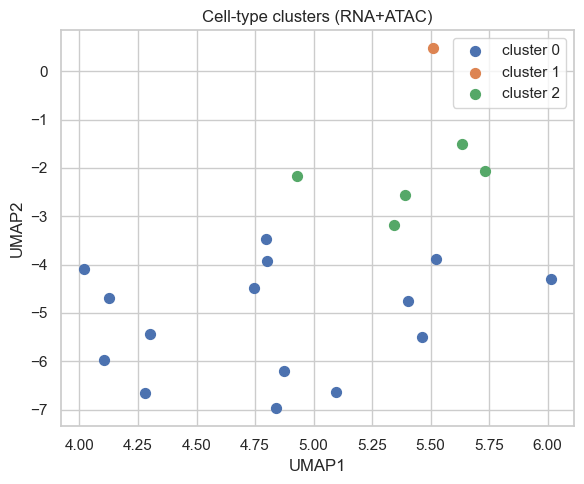

In [64]:
from sklearn.cluster import KMeans

# Clustering
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=0)
clusters_raw_3 = km.fit_predict(X)

# attach back to a DataFrame for easy plotting
embed_df_raw_3 = pd.DataFrame(
    umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=0)
      .fit_transform(X),
    index=rna_t.index,
    columns=["UMAP1", "UMAP2"]
)
embed_df_raw_3["cluster"] = clusters_raw_3

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
for c in np.unique(clusters_raw_3):
    idx = embed_df_raw["cluster"] == c
    plt.scatter(embed_df_raw_3.loc[idx,"UMAP1"],
                embed_df_raw_3.loc[idx,"UMAP2"],
                label=f"cluster {c}", s=50)
plt.legend()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Cell-type clusters (RNA+ATAC)")
plt.tight_layout()
plt.show()

In [65]:
cluster_to_cells = (
    embed_df_raw_3
    .groupby("cluster")
    .apply(lambda df: list(df.index))
    .to_dict()
)

for cl, cells in cluster_to_cells.items():
    print(f"Cluster {cl}:")
    for ct in cells:
        print("  ", ct)


Cluster 0:
   T.DP.Th
   T.4.Th
   T.8.Th
   T.4.Nve.Sp
   T.4.Nve.Fem.Sp
   T.8.Nve.Sp
   Treg.4.25hi.Sp
   T8.TN.P14.Sp
   T8.Tcm.LCMV.d180.Sp
   T8.Tem.LCMV.d180.Sp
   NKT.Sp
   NKT.Sp.LPS.3hr
   NKT.Sp.LPS.18hr
   NKT.Sp.LPS.3d
Cluster 1:
   preT.DN1.Th
   preT.DN2a.Th
   LTHSC.34-.BM
   LTHSC.34+.BM
   STHSC.150-.BM
   MPP4.135+.BM
Cluster 2:
   preT.DN2b.Th
   preT.DN3.Th
   T.DN4.Th
   T.ISP.Th
   T.4.Sp.aCD3+CD40.18hr
   Treg.4.FP3+.Nrplo.Co
   T8.TE.LCMV.d7.Sp
   T8.MP.LCMV.d7.Sp
   T8.IEL.LCMV.d7.Gut


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_26372\1940963466.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(df.index))


In [85]:
cluster_to_cells = (
    embed_df_raw_3
    .groupby("cluster")
    .apply(lambda df: list(df.index))
    .to_dict()
)

for cl, cells in cluster_to_cells.items():
    print(f"Cluster {cl}:")
    for ct in cells:
        group = group_series.get(ct, "Unknown")
        print(f"  {ct} ({group})")

Cluster 0:
  T.DP.Th (abT)
  T.4.Th (abT)
  T.8.Th (abT)
  T.4.Nve.Sp (abT)
  T.4.Nve.Fem.Sp (abT)
  T.8.Nve.Sp (abT)
  Treg.4.25hi.Sp (abT)
  T8.TN.P14.Sp (abT)
  T8.Tcm.LCMV.d180.Sp (Tact)
  T8.Tem.LCMV.d180.Sp (Tact)
  NKT.Sp (NKT)
  NKT.Sp.LPS.3hr (NKT)
  NKT.Sp.LPS.18hr (NKT)
  NKT.Sp.LPS.3d (NKT)
Cluster 1:
  preT.DN1.Th (abT)
  preT.DN2a.Th (abT)
  LTHSC.34-.BM (Progenitor)
  LTHSC.34+.BM (Progenitor)
  STHSC.150-.BM (Progenitor)
  MPP4.135+.BM (Progenitor)
Cluster 2:
  preT.DN2b.Th (abT)
  preT.DN3.Th (abT)
  T.DN4.Th (abT)
  T.ISP.Th (abT)
  T.4.Sp.aCD3+CD40.18hr (Tact)
  Treg.4.FP3+.Nrplo.Co (abT)
  T8.TE.LCMV.d7.Sp (Tact)
  T8.MP.LCMV.d7.Sp (Tact)
  T8.IEL.LCMV.d7.Gut (Unknown)


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_26372\531650310.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(df.index))


In cluster 1 there is only one cell which seems to be part of cluster 3, so we will merge both clusters.

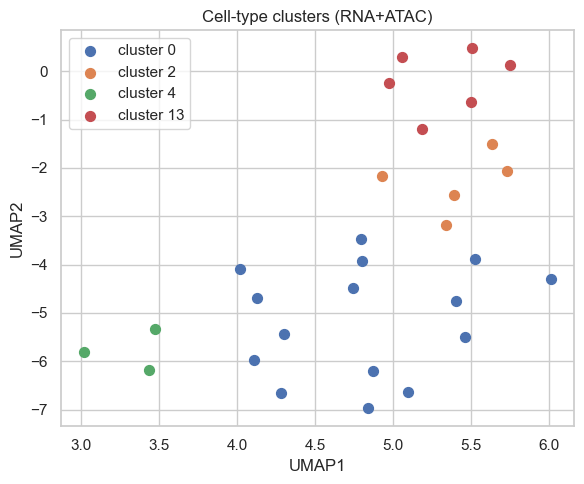

In [67]:
# Convert to Series for easier manipulation
cluster_series_raw = pd.Series(clusters_raw, index=rna_t.index)

# Merge Cluster 1 and Cluster 3 into a new cluster label 
merged_clusters_raw = cluster_series_raw.replace({1: 13, 3: 13})

# Update embed_df
embed_df_raw["merged_cluster_raw"] = merged_clusters_raw

# Plot 
plt.figure(figsize=(6,5))
for c in np.unique(embed_df_raw["merged_cluster_raw"]):
    idx = embed_df_raw["merged_cluster_raw"] == c
    plt.scatter(embed_df_raw.loc[idx,"UMAP1"],
                embed_df_raw.loc[idx,"UMAP2"],
                label=f"cluster {c}", s=50)

plt.legend()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Cell-type clusters (RNA+ATAC)")
plt.tight_layout()
plt.show()

In [68]:
cluster_to_cells = (
    embed_df_raw
    .groupby("merged_cluster_raw")
    .apply(lambda df: list(df.index))
    .to_dict()
)

for cl, cells in cluster_to_cells.items():
    print(f"Cluster {cl}:")
    for ct in cells:
        print("  ", ct)


Cluster 0:
   T.4.Th
   T.8.Th
   T.4.Nve.Sp
   T.4.Nve.Fem.Sp
   T.4.Sp.aCD3+CD40.18hr
   T.8.Nve.Sp
   Treg.4.25hi.Sp
   Treg.4.FP3+.Nrplo.Co
   T8.TN.P14.Sp
   T8.Tcm.LCMV.d180.Sp
   T8.Tem.LCMV.d180.Sp
   NKT.Sp
   NKT.Sp.LPS.3hr
   NKT.Sp.LPS.18hr
   NKT.Sp.LPS.3d
Cluster 2:
   preT.DN2b.Th
   preT.DN3.Th
   T.DN4.Th
   T.ISP.Th
   T.DP.Th
Cluster 4:
   T8.TE.LCMV.d7.Sp
   T8.MP.LCMV.d7.Sp
   T8.IEL.LCMV.d7.Gut
Cluster 13:
   preT.DN1.Th
   preT.DN2a.Th
   LTHSC.34-.BM
   LTHSC.34+.BM
   STHSC.150-.BM
   MPP4.135+.BM


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_26372\2055547189.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(df.index))


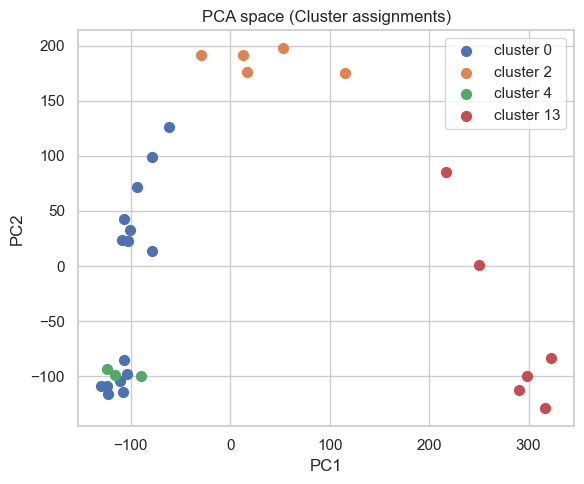

In [69]:
# Plot in PCA space to confirm meaningful clustering
from sklearn.decomposition import PCA
pca2d = PCA(n_components=2).fit_transform(X)
pca_df = pd.DataFrame(pca2d, columns=["PC1", "PC2"], index=rna_t.index)
pca_df["cluster"] = embed_df_raw["merged_cluster_raw"]

# Plot
plt.figure(figsize=(6,5))
for c in np.unique(pca_df["cluster"]):
    idx = pca_df["cluster"] == c
    plt.scatter(pca_df.loc[idx,"PC1"], pca_df.loc[idx,"PC2"], label=f"cluster {c}", s=50)
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA space (Cluster assignments)")
plt.tight_layout()
plt.show()


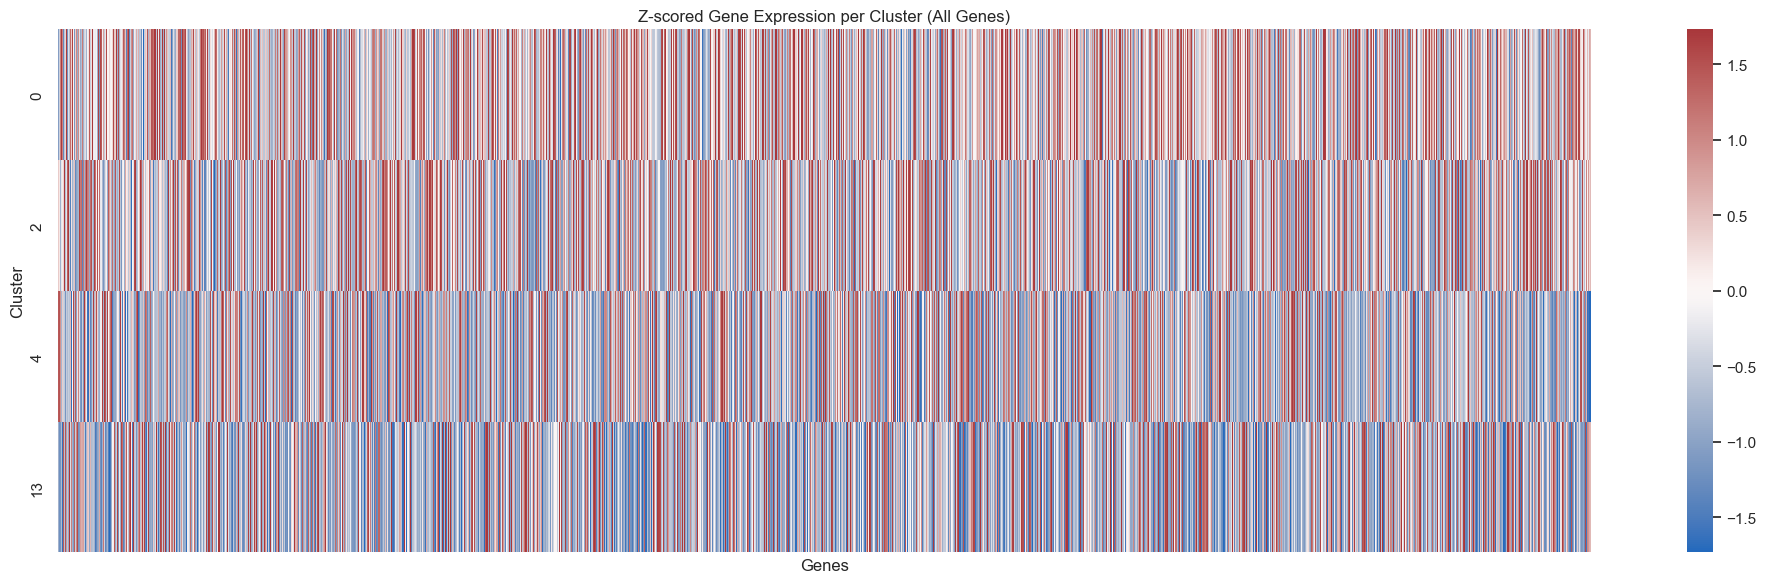

In [70]:
# Visualise with heatmap
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# Re-attach cluster labels if needed
rna_t["cluster"] = embed_df_raw["merged_cluster_raw"]

# Compute cluster-wise mean expression for all genes
rna_cluster_means = rna_t.groupby("cluster").mean()

# Drop the cluster column to avoid side effects
rna_t.drop(columns="cluster", inplace=True)

# Apply z-score across clusters (rows) per gene
rna_cluster_means_z = rna_cluster_means.apply(zscore, axis=0)

# Plot heatmap
plt.figure(figsize=(20, 6))  # Wider figure to fit many genes
sns.heatmap(rna_cluster_means_z, cmap="vlag", center=0, xticklabels=False, yticklabels=True)
plt.title("Z-scored Gene Expression per Cluster (All Genes)")
plt.xlabel("Genes")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


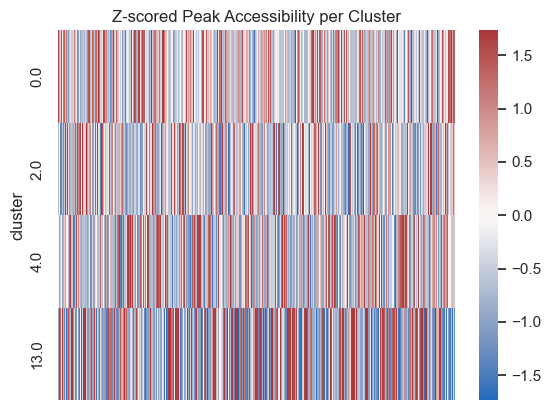

In [71]:
peak_t["cluster"] = embed_df_raw["merged_cluster_raw"]
peak_cluster_means = peak_t.groupby("cluster").mean()
peak_t.drop(columns="cluster", inplace=True)

from scipy.stats import zscore
peak_cluster_means_z = peak_cluster_means.apply(zscore, axis=0)

sns.heatmap(peak_cluster_means_z, cmap="vlag", center=0,
            xticklabels=False, yticklabels=True)
plt.title("Z-scored Peak Accessibility per Cluster")
plt.show()


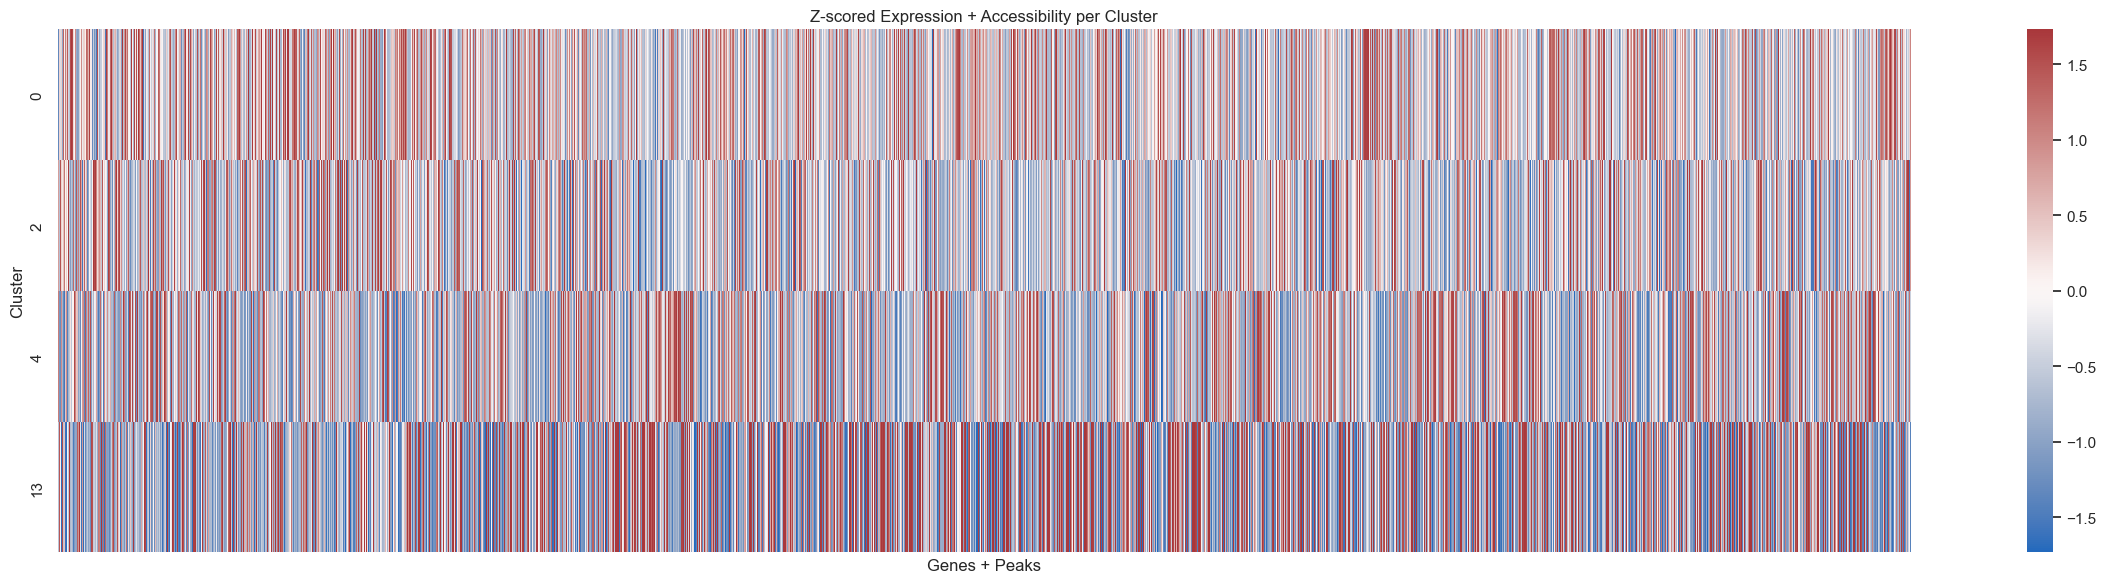

In [72]:
# Add cluster labels to both datasets
rna_t["cluster"] = embed_df_raw["merged_cluster_raw"]
peak_t["cluster"] = embed_df_raw["merged_cluster_raw"]

# Compute cluster-wise means
rna_cluster_means = rna_t.groupby("cluster").mean()
peak_cluster_means = peak_t.groupby("cluster").mean()

# Drop cluster columns afterward
rna_t.drop(columns="cluster", inplace=True)
peak_t.drop(columns="cluster", inplace=True)

# Concatenate across columns (genes + peaks)
combined_means = pd.concat([rna_cluster_means, peak_cluster_means], axis=1)

# Z-score per feature (i.e., column)
from scipy.stats import zscore
combined_means_z = combined_means.apply(zscore, axis=0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 6))  # Wider to accommodate many features
sns.heatmap(combined_means_z, cmap="vlag", center=0,
            xticklabels=False, yticklabels=True)
plt.title("Z-scored Expression + Accessibility per Cluster")
plt.xlabel("Genes + Peaks")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


Red: feature is accessible/upregulated in that cluster

blue: feature is downregulated/closed in that cluster

white: feature is at average level across clusters

In [73]:
# Add prefixes for clarity
rna_named = rna_t.add_prefix("gene_")
peak_named = peak_t.add_prefix("peak_")

# Combine into one full matrix
combined_data = pd.concat([rna_named, peak_named], axis=1)

# Add cluster label
combined_data["cluster"] = embed_df_raw["merged_cluster_raw"]

# Group by cluster
clusters_raw = combined_data["cluster"].unique()
cluster_dfs = {}

for cid in clusters_raw:
    df = combined_data[combined_data["cluster"] == cid].drop(columns="cluster")
    cluster_dfs[cid] = df

for cid, df in cluster_dfs.items():
    print(f"Cluster {cid} — shape: {df.shape}")
    display(df.head())



Cluster 13.0 — shape: (6, 93392)


gene_0      gene_1     gene_2     gene_3      gene_4  \
preT.DN1.Th    1.022363  162.641117  68.070719  15.450717  160.246297   
preT.DN2a.Th   1.389747  206.945221  82.468806  13.573968  125.475307   
LTHSC.34-.BM   1.096732  206.053987  78.272059   8.577159  168.645852   
LTHSC.34+.BM   1.096732  246.105317  78.837030  16.791386  157.926022   
STHSC.150-.BM  1.021750  192.424636  68.844751  15.511549  155.941641   

                   gene_5      gene_6      gene_7      gene_8      gene_9  \
preT.DN1.Th    155.767862  146.959609  108.511521  147.315383  110.833671   
preT.DN2a.Th   273.998186  166.023337  110.892076  146.009167  137.259987   
LTHSC.34-.BM    75.934142  149.566205   93.915285  139.978638  200.799343   
LTHSC.34+.BM   172.175681  201.786082   94.031495  154.170669  193.643339   
STHSC.150-.BM  119.156447  155.028950   79.327033  122.703765  238.761950   

               ...  peak_75847  peak_75848  peak_75849  peak_75850  \
preT.DN1.Th    ...       26.59       19.05       24.77       34.10   
preT.DN2a.Th   ...       15.01       10.46       30.09       37.56   
LTHSC.34-.BM   ...       16.15       12.99       19.40       26.12   
LTHSC.34+.BM   ...       13.37       11.79       25.33       15.01   
STHSC.150-.BM  ...       10.26        9.19       17.12       23.45   

               peak_75851  peak_75852  peak_75853  peak_75854  peak_75855  \
preT.DN1.Th          3.47       16.26        9.35        7.02       15.76   
preT.DN2a.Th         3.22       15.23       13.75       11.95       19.36   
LTHSC.34-.BM         4.37        0.41        0.41        7.00        2.36   
LTHSC.34+.BM         0.71        8.79        8.79       10.26        7.41   
STHSC.150-.BM        3.52        8.12        0.90        6.13        2.69   

               peak_75856  
preT.DN1.Th         12.97  
preT.DN2a.Th        16.90  
LTHSC.34-.BM         4.37  
LTHSC.34+.BM        13.37  
STHSC.150-.BM       12.56  

[5 rows x 93392 columns]

Cluster 2.0 — shape: (5, 93392)


gene_0      gene_1     gene_2     gene_3      gene_4  \
preT.DN2b.Th  1.024819  209.187788  89.769337  14.427620  155.928005   
preT.DN3.Th   1.024482  198.421365  57.661619   8.249482  120.692893   
T.DN4.Th      1.026430  215.056475  76.399214   1.683173  118.433597   
T.ISP.Th      1.026217  225.565360  84.671456   4.001953  149.630866   
T.DP.Th       3.010920   73.904647  32.828651   5.595954   92.040668   

                  gene_5      gene_6      gene_7      gene_8      gene_9  ...  \
preT.DN2b.Th  154.269870  245.243593   71.760450  161.827642  124.749368  ...   
preT.DN3.Th   129.834226  225.662176   78.986667  187.582633  178.268286  ...   
T.DN4.Th      197.843435  252.196726   99.422042  153.613650  152.467579  ...   
T.ISP.Th      173.726109  245.295957  108.769196  163.657839  172.220431  ...   
T.DP.Th        58.203391   84.157303   51.185755  102.272843  344.760383  ...   

              peak_75847  peak_75848  peak_75849  peak_75850  peak_75851  \
preT.DN2b.Th       16.36       11.95       47.10       33.86        4.83   
preT.DN3.Th        22.34       24.17       38.09       37.96        5.90   
T.DN4.Th           13.57       16.93       34.49       34.34        9.35   
T.ISP.Th           24.57       25.02       17.63       22.33       19.77   
T.DP.Th            16.52       14.67       23.97       21.58        1.09   

              peak_75852  peak_75853  peak_75854  peak_75855  peak_75856  
preT.DN2b.Th       23.51       25.28       17.03       18.31       17.03  
preT.DN3.Th        17.92       15.38       19.55       18.56        9.20  
T.DN4.Th           33.73       24.35       27.28       19.63       17.73  
T.ISP.Th           27.09        8.98       26.47       28.75       11.25  
T.DP.Th             5.14        2.45        5.14        8.09        4.07  

[5 rows x 93392 columns]

Cluster 0.0 — shape: (15, 93392)


gene_0      gene_1     gene_2     gene_3      gene_4  \
T.4.Th                 1.024462  138.841383  27.207241   6.367369   76.781112   
T.8.Th                 1.024819  139.863904  36.169759   6.505833   87.529814   
T.4.Nve.Sp             2.726341  168.924363  32.753248   8.262234   86.523573   
T.4.Nve.Fem.Sp         1.025543  158.793983  17.622002  20.215212   86.846055   
T.4.Sp.aCD3+CD40.18hr  1.025785  317.547722  88.070293   7.237301  149.727916   

                          gene_5      gene_6      gene_7      gene_8  \
T.4.Th                 42.950719  204.219996   51.087503   98.714813   
T.8.Th                 26.099208  198.168772   80.225632  152.804895   
T.4.Nve.Sp             40.183229  199.553377  111.861459  114.754020   
T.4.Nve.Fem.Sp         24.099340  191.324154  126.991292  119.563956   
T.4.Sp.aCD3+CD40.18hr  54.181034  213.851818   70.390532  229.810650   

                           gene_9  ...  peak_75847  peak_75848  peak_75849  \
T.4.Th                 258.276924  ...       20.73       23.23       30.40   
T.8.Th                 205.366284  ...       27.37       30.70       32.23   
T.4.Nve.Sp             303.257810  ...       12.31       16.08       32.92   
T.4.Nve.Fem.Sp         274.976658  ...        0.86        0.86        0.15   
T.4.Sp.aCD3+CD40.18hr  136.798048  ...       17.01       24.67       19.25   

                       peak_75850  peak_75851  peak_75852  peak_75853  \
T.4.Th                      36.57       12.68       22.06       11.87   
T.8.Th                      42.92       18.14       13.74       12.08   
T.4.Nve.Sp                  40.30        3.23       13.83        7.38   
T.4.Nve.Fem.Sp               0.15        6.90       14.24        9.40   
T.4.Sp.aCD3+CD40.18hr       41.25        6.26       12.70        8.00   

                       peak_75854  peak_75855  peak_75856  
T.4.Th                      20.73       13.13       11.25  
T.8.Th                      10.60       16.70       17.19  
T.4.Nve.Sp                   7.53       13.30       18.83  
T.4.Nve.Fem.Sp              12.43       10.09       13.15  
T.4.Sp.aCD3+CD40.18hr        8.58       10.86        7.11  

[5 rows x 93392 columns]

Cluster 4.0 — shape: (3, 93392)


gene_0      gene_1     gene_2     gene_3      gene_4  \
T8.TE.LCMV.d7.Sp    1.026268  243.415772  46.641598  17.559327   88.323183   
T8.MP.LCMV.d7.Sp    1.026558  209.550877  40.467261  16.149115  101.436086   
T8.IEL.LCMV.d7.Gut  1.026268  248.699380  29.061552  17.279400  108.027266   

                       gene_5      gene_6      gene_7      gene_8      gene_9  \
T8.TE.LCMV.d7.Sp    72.124325  244.078146   77.158770  154.892637  184.851523   
T8.MP.LCMV.d7.Sp    61.690037  221.474286  140.699098  181.471260  155.886833   
T8.IEL.LCMV.d7.Gut  31.809652  207.110616   81.906366  158.649515  118.011619   

                    ...  peak_75847  peak_75848  peak_75849  peak_75850  \
T8.TE.LCMV.d7.Sp    ...       19.58       21.39       24.43       31.04   
T8.MP.LCMV.d7.Sp    ...       14.77       16.62       25.25       26.79   
T8.IEL.LCMV.d7.Gut  ...         NaN         NaN         NaN         NaN   

                    peak_75851  peak_75852  peak_75853  peak_75854  \
T8.TE.LCMV.d7.Sp         16.23       16.45       12.06       10.74   
T8.MP.LCMV.d7.Sp         18.52       16.28       10.16        9.36   
T8.IEL.LCMV.d7.Gut         NaN         NaN         NaN         NaN   

                    peak_75855  peak_75856  
T8.TE.LCMV.d7.Sp          9.67        6.73  
T8.MP.LCMV.d7.Sp          6.86        5.49  
T8.IEL.LCMV.d7.Gut         NaN         NaN  

[3 rows x 93392 columns]

Cluster nan — shape: (0, 93392)


Empty DataFrame
Columns: [gene_0, gene_1, gene_2, gene_3, gene_4, gene_5, gene_6, gene_7, gene_8, gene_9, gene_10, gene_11, gene_12, gene_13, gene_14, gene_15, gene_16, gene_17, gene_18, gene_19, gene_20, gene_21, gene_22, gene_23, gene_24, gene_25, gene_26, gene_27, gene_28, gene_29, gene_30, gene_31, gene_32, gene_33, gene_34, gene_35, gene_36, gene_37, gene_38, gene_39, gene_40, gene_41, gene_42, gene_43, gene_44, gene_45, gene_46, gene_47, gene_48, gene_49, gene_50, gene_51, gene_52, gene_53, gene_54, gene_55, gene_56, gene_57, gene_58, gene_59, gene_60, gene_61, gene_62, gene_63, gene_64, gene_65, gene_66, gene_67, gene_68, gene_69, gene_70, gene_71, gene_72, gene_73, gene_74, gene_75, gene_76, gene_77, gene_78, gene_79, gene_80, gene_81, gene_82, gene_83, gene_84, gene_85, gene_86, gene_87, gene_88, gene_89, gene_90, gene_91, gene_92, gene_93, gene_94, gene_95, gene_96, gene_97, gene_98, gene_99, ...]
Index: []

[0 rows x 93392 columns]

This clusters from above dont really tell us anything since they are too overcrowded.

#### Compare including effect direction

In [154]:
import pandas as pd

reg = pd.read_csv("high_conf_filtered.csv")
print(reg.shape)
reg.head()

(28222, 7)


Unnamed: 0    gene                  peak_ID  coefficient        r2  \
0          13  Pcmtd1  ImmGenATAC1219.peak_376    -1.367742  0.752231   
1          14  Pcmtd1  ImmGenATAC1219.peak_377    -2.494725  0.752231   
2          15  Pcmtd1  ImmGenATAC1219.peak_378     3.276884  0.752231   
3          16  Pcmtd1  ImmGenATAC1219.peak_380     5.020475  0.752231   
4          17  Pcmtd1  ImmGenATAC1219.peak_408     0.983100  0.752231   

   distance_to_tss       role  
0            394.0  repressor  
1            144.0  repressor  
2            132.0   promoter  
3           7143.0  activator  
4          58306.0  activator

In [161]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap

# 1) Load your data
#    signal_matrix: rows = peak_ID (e.g. "ImmGenATAC1219.peak_376"), columns = cell types
peak_df = signal_matrix.copy()
reg     = pd.read_csv("high_conf_filtered.csv")

# 2) Find which peaks overlap by their full string ID
common_peaks = peak_df.index.intersection(reg["peak_ID"])
print(f"Common peaks found: {len(common_peaks)}")
# Expect >0. If still zero, your peak_df.index does not match reg["peak_ID"] exactly.

# 3) Subset to just those shared peaks
peak_sub = peak_df.loc[common_peaks]     # shape: (#common_peaks × #cells)

# 4) Pivot your regression table on the SAME string IDs
coef = (
    reg[reg["peak_ID"].isin(common_peaks)]
      .pivot(index="peak_ID", columns="gene", values="coefficient")
      .fillna(0)
)

Common peaks found: 0


In [155]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap

# Load input data
peak = signal_matrix                   
reg = pd.read_csv("high_conf_filtered.csv")  

# Transpose peak matrix (cell types × peaks)
peak_t = peak.T

# Extract peak index from full IDs like "ImmGenATAC1219.peak_376"
reg["peak_index"] = reg["peak_ID"].str.extract(r"peak_(\d+)$")[0].astype(int)

# Make sure peak_t columns are integers like in reg['peak_index']
peak_t.columns = peak_t.columns.astype(int)

# Create coefficient matrix: peaks × genes
coef = (
    reg
    .pivot(index="peak_ID", columns="gene", values="coefficient")
    .fillna(0)
)

# Intersect peaks
common_peaks = peak_t.columns.intersection(coef.index)
print(f"Common peaks found: {len(common_peaks)}")

Common peaks found: 0


We need to align the names.

In [156]:
print("Example peak_t column:", peak_t.columns[:5].tolist())
print("Example reg peak_ID:", reg['peak_ID'].unique()[:5])

Example peak_t column: [0, 1, 2, 3, 4]
Example reg peak_ID: ['ImmGenATAC1219.peak_376' 'ImmGenATAC1219.peak_377'
 'ImmGenATAC1219.peak_378' 'ImmGenATAC1219.peak_380'
 'ImmGenATAC1219.peak_408']


In [157]:
# Map column number (as string) → peak_ID
peak_index_to_id = reg.drop_duplicates("peak_ID").set_index("peak_index")["peak_ID"]

# Convert peak_t columns to int
peak_t.columns = peak_t.columns.astype(int)

# Keep only matching columns
valid_cols = peak_t.columns.intersection(peak_index_to_id.index)

# Subset peak_t and rename columns to match coef
peak_t = peak_t[valid_cols]
peak_t.columns = peak_index_to_id.loc[valid_cols].values


In [158]:
# Now build coef using the extracted peak_index
coef = (
    reg
    .pivot(index="peak_index", columns="gene", values="coefficient")
    .fillna(0)
)

# Get common peaks
common_peaks = peak_t.columns.intersection(coef.index)
print(f"Common peaks found: {len(common_peaks)}")


Common peaks found: 0


Common peaks found: 2946


c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\

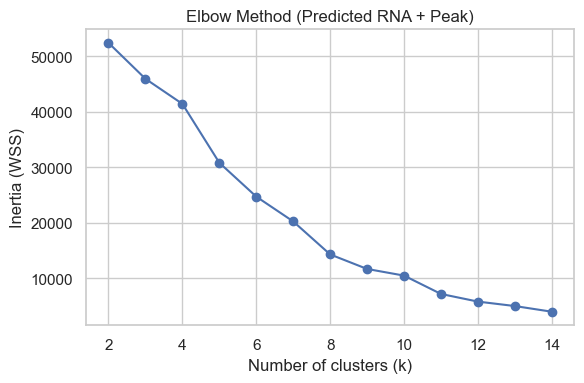

In [ ]:
# Subset and align
common_peaks = peak_t.columns.intersection(coef.index)
print(f"Common peaks found: {len(common_peaks)}")

# Select aligned peaks
peak_sub = peak_t[common_peaks]       
coef = coef.loc[common_peaks]  

# Predict gene expression from peaks
pred_expr = peak_sub.dot(coef)  

# Normalize & PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
peak_scaled = scaler.fit_transform(peak_sub)
expr_scaled = scaler.fit_transform(pred_expr)

pca_peak = PCA(n_components=10).fit_transform(peak_scaled)
pca_expr = PCA(n_components=10).fit_transform(expr_scaled)

X = np.hstack([pca_expr, pca_peak])  

# Elbow plot
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WSS)")
plt.title("Elbow Method (Predicted RNA + Peak)")
plt.grid(True)
plt.tight_layout()
plt.show()


k = 5

In [ ]:
print("df shape:", df.shape)
print("df index:", df.index)


df shape: (0, 93392)
df index: Index([], dtype='object')


In [ ]:
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# KMeans clustering 
n_clusters = 6
km = KMeans(n_clusters=n_clusters, random_state=0)
clusters = km.fit_predict(X)

# UMAP embedding
umap_embed = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=0).fit_transform(X)

# Create DataFrame for plotting
eembed_df_reg = pd.DataFrame(umap_embed, columns=["UMAP1", "UMAP2"], index=df.index)
embed_df_reg["cluster"] = clusters

# Plot UMAP
plt.figure(figsize=(6, 5))
for c in np.unique(clusters):
    idx = embed_df_reg["cluster"] == c
    plt.scatter(embed_df_reg.loc[idx, "UMAP1"],
                embed_df_reg.loc[idx, "UMAP2"],
                label=f"cluster {c}", s=50)
plt.legend()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Cell-type clusters (Predicted RNA + ATAC)")
plt.tight_layout()
plt.show()


c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: Shape of passed values is (29, 2), indices imply (0, 2)

In [ ]:
cluster_to_cells = (
    embed_df_reg
    .groupby("cluster")
    .apply(lambda df: list(df.index))
    .to_dict()
)

for cl, cells in cluster_to_cells.items():
    print(f"Cluster {cl}:")
    for ct in cells:
        print("  ", ct)

Cluster 0:
   T.4.Nve.Sp
   T.4.Nve.Fem.Sp
   T.8.Nve.Sp
   T8.TN.P14.Sp
Cluster 1:
   preT.DN1.Th
   LTHSC.34-.BM
   LTHSC.34+.BM
   STHSC.150-.BM
   MPP4.135+.BM
Cluster 2:
   T8.Tcm.LCMV.d180.Sp
   T8.Tem.LCMV.d180.Sp
   NKT.Sp
   NKT.Sp.LPS.3hr
   NKT.Sp.LPS.18hr
   NKT.Sp.LPS.3d
Cluster 3:
   T.DP.Th
   T.4.Th
   T.8.Th
   Treg.4.25hi.Sp
Cluster 4:
   T.4.Sp.aCD3+CD40.18hr
   Treg.4.FP3+.Nrplo.Co
   T8.TE.LCMV.d7.Sp
   T8.MP.LCMV.d7.Sp
Cluster 5:
   preT.DN2a.Th
   preT.DN2b.Th
   preT.DN3.Th
   T.DN4.Th
   T.ISP.Th


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_7704\2819026976.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(df.index))


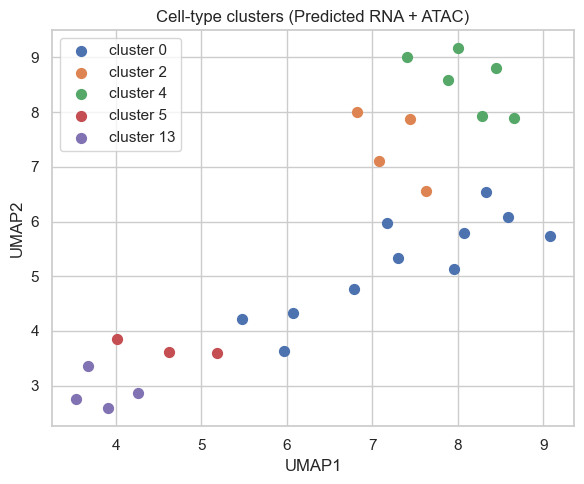

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Make a copy of cluster labels
merged_cluster_reg = embed_df["cluster"].copy()

# Merge cluster 1 and 3 into a new label 
merged_cluster_raw = merged_cluster_reg.replace({1: 13, 3: 13})
embed_df["merged_cluster"] = merged_cluster_raw

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))
for c in np.unique(embed_df["merged_cluster"]):
    idx = embed_df["merged_cluster"] == c
    plt.scatter(embed_df.loc[idx, "UMAP1"],
                embed_df.loc[idx, "UMAP2"],
                label=f"cluster {c}", s=50)

plt.legend()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Cell-type clusters (Predicted RNA + ATAC)")
plt.tight_layout()
plt.show()

In [ ]:
# Group by merged cluster and collect the cell type names (index)
cluster_to_cells = (
    embed_df
    .groupby("merged_cluster")
    .apply(lambda df: list(df.index))
    .to_dict()
)

# Print the results
for cl, cells in cluster_to_cells.items():
    print(f"\nCluster {cl}:")
    for ct in cells:
        print("  ", ct)



Cluster 0:
   preT.DN3.Th
   T.DN4.Th
   T.ISP.Th
   T.DP.Th
   T.4.Th
   T.8.Th
   T.4.Nve.Sp
   T.4.Nve.Fem.Sp
   T.8.Nve.Sp
   Treg.4.25hi.Sp
   T8.TN.P14.Sp

Cluster 2:
   T.4.Sp.aCD3+CD40.18hr
   Treg.4.FP3+.Nrplo.Co
   T8.TE.LCMV.d7.Sp
   T8.MP.LCMV.d7.Sp

Cluster 4:
   T8.Tcm.LCMV.d180.Sp
   T8.Tem.LCMV.d180.Sp
   NKT.Sp
   NKT.Sp.LPS.3hr
   NKT.Sp.LPS.18hr
   NKT.Sp.LPS.3d

Cluster 5:
   preT.DN1.Th
   preT.DN2a.Th
   preT.DN2b.Th

Cluster 13:
   LTHSC.34-.BM
   LTHSC.34+.BM
   STHSC.150-.BM
   MPP4.135+.BM


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_7704\53837678.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(df.index))


The cells cluster the same as in the raw version.

Trying to see if we have activators for specific genes

In [ ]:
# Get the common cells
common_cells = embed_df.index.intersection(rna_t.index).intersection(peak_t.index)
print(f"Using {len(common_cells)} common cells")


Using 28 common cells


In [ ]:
# Restrict all to the common cells
embed_df = embed_df_reg.loc[common_cells]
rna_t = rna_t.loc[common_cells]
peak_t = peak_t.loc[common_cells]

# Update cell_clusters after filtering
cell_clusters_reg = embed_df["cluster"]


In [ ]:
peak_ids_in_peak_t = reg["peak_ID"].isin(peak_t.columns).sum()
genes_in_rna_t = reg["gene"].isin(rna_t.columns).sum()

print(f"Peaks in peak_t: {peak_ids_in_peak_t} / {len(reg)}")
print(f"Genes in rna_t:  {genes_in_rna_t} / {len(reg)}")


Peaks in peak_t: 3844 / 28222
Genes in rna_t:  0 / 28222


In [ ]:
import pandas as pd

# Load RNA expression with gene names as columns
rna = pd.read_csv("filtered_RNA_abT_Tact_Stem.csv", index_col=0)

# Transpose so that rows = cell types, columns = genes
rna_t = rna.T

# Confirm it's fixed
print("First few genes:", rna_t.columns[:5])


First few genes: Index(['0610005C13Rik', '0610007P14Rik', '0610009B22Rik', '0610009L18Rik',
       '0610009O20Rik'],
      dtype='object')


In [ ]:
from scipy.stats import pearsonr

results_reg = []

for _, row in reg.iterrows():
    peak = row["peak_ID"]
    gene = row["gene"]
    coef = row["coefficient"]

    try:
        peak_vals = peak_t[peak]
        gene_vals = rna_t[gene]
    except KeyError:
        continue

    # Align by index (cell names)
    common_cells = peak_vals.index.intersection(gene_vals.index)
    x = peak_vals.loc[common_cells]
    y = gene_vals.loc[common_cells]

    # Skip if not enough data
    if len(x) < 2:
        continue

    r, _ = pearsonr(x, y)

    for clust in sorted(cell_clusters_reg.unique()):
        cells = cell_clusters_reg[cell_clusters_reg == clust].index
        cells = cells.intersection(common_cells)

        if len(cells) == 0:
            continue

        peak_mean = x.loc[cells].mean()
        gene_mean = y.loc[cells].mean()
        is_active = (peak_mean > x.mean()) and (gene_mean > y.mean())

        results_reg.append({
            "cluster": clust,
            "peak": peak,
            "gene": gene,
            "coef": coef,
            "corr": r,
            "is_active": is_active,
            "type": "activator" if coef > 0 else "repressor"
        })

print(f"Number of CRE entries processed: {len(results_reg)}")


Number of CRE entries processed: 19220


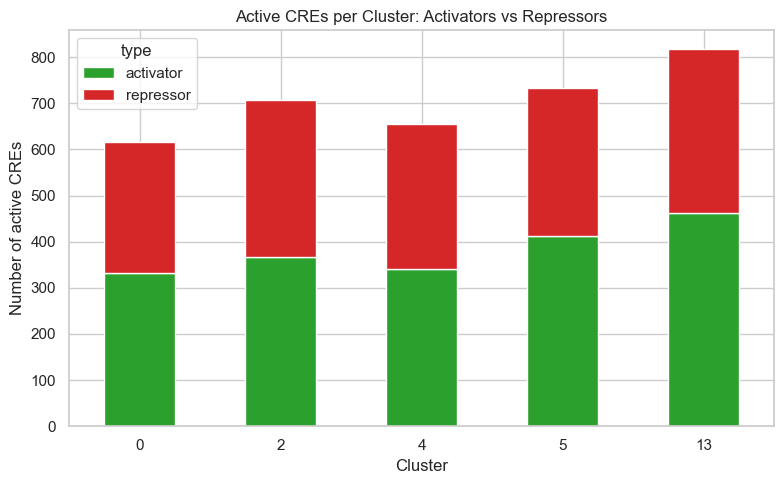

In [ ]:
# Convert results to data frame
result_df_reg = pd.DataFrame(results_reg)

# Filter to active CREs (where both peak & gene are active in the same cluster)
active_cre = result_df_reg[result_df_reg["is_active"]]

# Count activators vs repressors per cluster
# Count activators and repressors
summary = (
    active_cre
    .groupby(["cluster", "type"])
    .size()
    .unstack(fill_value=0)
)

# Compute percentage
summary["total"] = summary.sum(axis=1)
summary["%_activator"] = 100 * summary["activator"] / summary["total"]
summary["%_repressor"] = 100 * summary["repressor"] / summary["total"]

summary = summary.fillna(0)
summary

# Plot bar chart
import matplotlib.pyplot as plt

summary[["activator", "repressor"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8,5),
    color=["#2ca02c", "#d62728"]
)

plt.ylabel("Number of active CREs")
plt.xlabel("Cluster")
plt.title("Active CREs per Cluster: Activators vs Repressors")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Now we want to know: **Are the clusters from A (ATAC/RNA data) and B(regression results) significantly different or similar?**

In [ ]:
labels_a = clusters_raw  # from Clustering A
labels_b = cell_clusters_reg.values       # from Clustering B


In [ ]:
import numpy as np

print("NaNs in labels_a:", np.isnan(labels_a).sum())
print("NaNs in labels_b:", np.isnan(labels_b).sum())


NaNs in labels_a: 1
NaNs in labels_b: 0


In [ ]:
print("clusters_raw:", len(clusters_raw))
print("embed_df:", embed_df.shape)


clusters_raw: 6
embed_df: (28, 4)


In [ ]:
print(f"len(clusters): {len(clusters)}")
print(f"len(embed_df): {len(embed_df)}")


len(clusters): 29
len(embed_df): 28


In [ ]:
from sklearn.cluster import KMeans

X = embed_df[["UMAP1", "UMAP2"]]  # or whatever features you used
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(X)

clusters_raw = pd.Series(clusters, index=embed_df.index)


c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
clusters_raw = pd.Series(clusters, index=embed_df.index)


In [ ]:
# Assume clusters_raw and cell_clusters_reg are pandas Series
# Make sure both have the cell names as index
clusters_a = pd.Series(clusters_raw, index=embed_df.index)  # clustering A
clusters_b = cell_clusters_reg                              # clustering B

# Align on shared cells
common_idx = clusters_a.index.intersection(clusters_b.index)
labels_a = clusters_a.loc[common_idx]
labels_b = clusters_b.loc[common_idx]

# Remove any NaNs just in case
mask = labels_a.notna() & labels_b.notna()
labels_a_clean = labels_a[mask].astype(int).values
labels_b_clean = labels_b[mask].astype(int).values

# Compute comparison metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_a_clean, labels_b_clean)
nmi = normalized_mutual_info_score(labels_a_clean, labels_b_clean)

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")


Adjusted Rand Index (ARI): 0.545
Normalized Mutual Information (NMI): 0.784


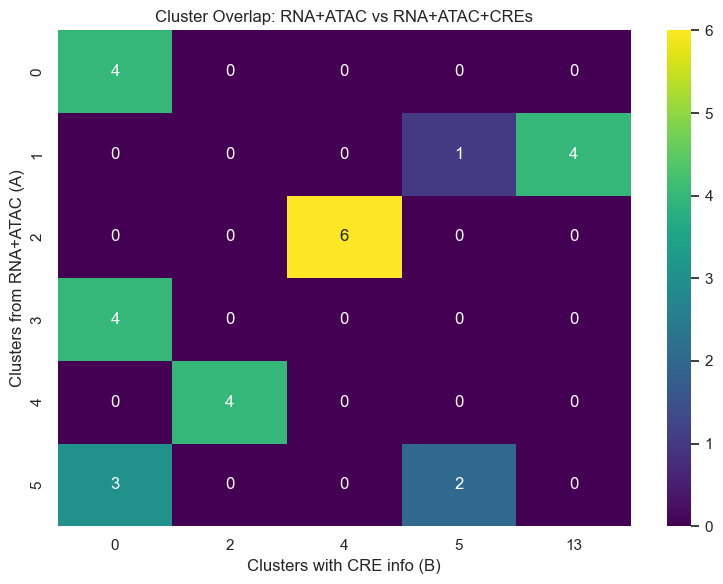

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming:
# - clusters_a: Series of cluster labels from RNA+ATAC (clustering A)
# - clusters_b: Series of cluster labels from RNA+ATAC+CRE effect (clustering B)
# Both indexed by cell names

# Combine into a DataFrame
overlap_df = pd.DataFrame({
    "Cluster_A": clusters_a,
    "Cluster_B": clusters_b
})

# Compute contingency table (overlap counts)
contingency = pd.crosstab(overlap_df["Cluster_A"], overlap_df["Cluster_B"])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency, annot=True, fmt='d', cmap="viridis", cbar=True)
plt.xlabel("Clusters with CRE info (B)")
plt.ylabel("Clusters from RNA+ATAC (A)")
plt.title("Cluster Overlap: RNA+ATAC vs RNA+ATAC+CREs")
plt.tight_layout()
plt.show()


What proportion of cells from each RNA+ATAC cluster end up in each RNA+ATAC+CRE cluster?

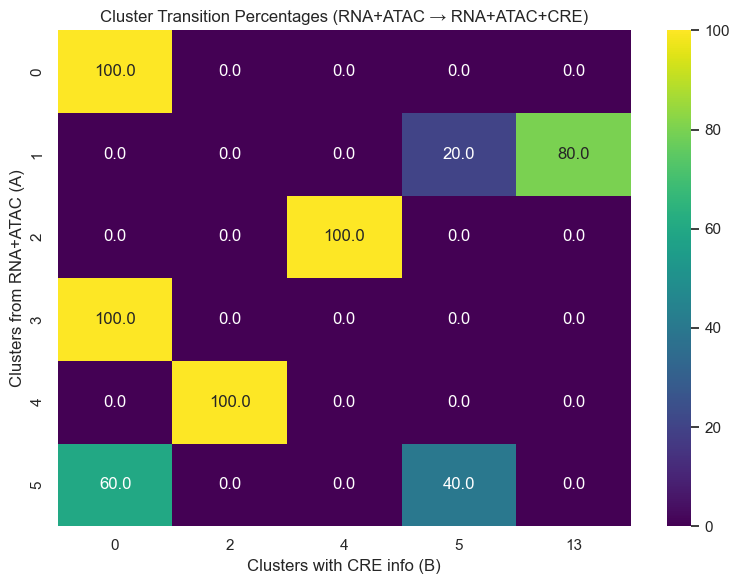

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create contingency matrix
contingency = pd.crosstab(clusters_a, clusters_b)

# Normalize row-wise (percent within each original cluster)
percentage_matrix = contingency.div(contingency.sum(axis=1), axis=0) * 100

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_matrix, annot=True, fmt=".1f", cmap="viridis")

plt.title("Cluster Transition Percentages (RNA+ATAC → RNA+ATAC+CRE)")
plt.xlabel("Clusters with CRE info (B)")
plt.ylabel("Clusters from RNA+ATAC (A)")
plt.tight_layout()
plt.show()


What proportion of each RNA+ATAC+CRE cluster originated from each RNA+ATAC cluster?

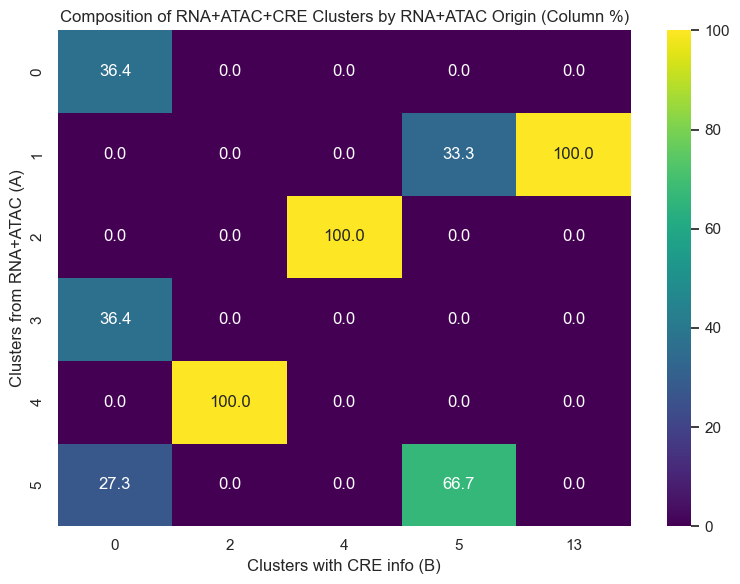

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create contingency table
contingency = pd.crosstab(clusters_a, clusters_b)

# Normalize column-wise (percent within each RNA+ATAC+CRE cluster)
percentage_matrix_col = contingency.div(contingency.sum(axis=0), axis=1) * 100

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_matrix_col, annot=True, fmt=".1f", cmap="viridis")

plt.title("Composition of RNA+ATAC+CRE Clusters by RNA+ATAC Origin (Column %)")
plt.xlabel("Clusters with CRE info (B)")
plt.ylabel("Clusters from RNA+ATAC (A)")
plt.tight_layout()
plt.show()
